In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Lambda
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
import argparse
import os
import math

import sys
import csv
import re
import random
import copy
from skimage.transform import downscale_local_mean
from skimage import io
import numpy as np
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Multiply, Input, Dropout, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, MaxPooling2D, MaxPooling3D, UpSampling2D, Dense, Flatten, Activation, Reshape, BatchNormalization, LeakyReLU, PReLU
from keras.optimizers import RMSprop, Adam
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras import initializers

Using TensorFlow backend.


In [2]:
data_root = 'D:/HDD Data/cartoons/'
output_root = 'D:/HDD Data/cartoon-gan'
random.seed()

In [3]:
def load_metadata():
    metadata = []
    with open(data_root + 'metadata.csv', 'r', newline='') as metadata_file:
        reader = csv.reader(metadata_file, quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            metadatum = row[:2] + [int(n) for n in re.findall(r'\d+', row[2])]
            metadata.append(metadatum)
    return metadata

In [4]:
metadata = load_metadata()
random.shuffle(metadata)
metadata_train = metadata[len(metadata)//10:]
metadata_test = metadata[:len(metadata_train)]
num_data = len(metadata)

classes = set([datum[0] for datum in metadata])
# build a dictionary mapping between name strings and ids
class_to_id = dict((n, i) for i, n in enumerate(classes))
id_to_class = dict((i, n) for i, n in enumerate(classes))
num_classes = len(classes)

In [5]:
# 1 is white, 0 is black, remember
def convert_to_sample(img, latent_category):
    return np.random.rand(*img.shape)

def flat_vector(img, latent_category):
    return np.random.rand(100)


class DataProvider(Sequence):

    metadata = None
    batch_size = 1 # because I get OOM otherwise
    
    def __init__(self, metadata, first_category_only=False, get_input_vector=flat_vector):
        self.metadata = metadata
        self.first_category_only = first_category_only
        self.get_input_vector = get_input_vector
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        x, y = self.get_batch(self.batch_size, self.metadata)
        if x is None or y is None:
            raise ValueError("input x or y is none")
        return x, y

    # note to self for the future: optimize the batches to use np arrays from the getgo?
    def get_batch(self, batch_size, metadata):
        img_x, img_y = 150, 450
        batch_x = np.zeros((batch_size, img_x, img_y), dtype=float)
        batch_y = np.zeros((batch_size, img_x, img_y), dtype=float)
        for i in range(batch_size):
            img_scaled = None
            datum_index = random.randint(0, len(metadata)-1)
            j = 0
            while img_scaled is None:
                metadatum = metadata[(datum_index + j) % len(metadata)]
                latent_category = class_to_id[metadatum[0]]
                if latent_category == num_classes-1 or self.first_category_only is False:
                    img_scaled = self.get_image(metadata, (datum_index + j) % len(metadata))
                else:
                    img_scaled = None
                j += 1
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2))
            # normalize channel values
            batch_y[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'maximum')
            batch_y[i] /= 255.0
            batch_x = self.get_input_vector(batch_y, latent_category)
        #return np.expand_dims(batch_x, axis=3), np.expand_dims(batch_y, axis=3)
        return batch_x.reshape(1,-1), np.expand_dims(batch_y, axis=3)

    # if outside the tolerance range, return None (it's not a valid datum)
    # if to large, crop from both sides to fit
    # if to small, pad with maximum value (white) to fit
    def scale_to_target(self, image, initial_y, target_y, shrink_tolerance, grow_tolerance):
        if(target_y-initial_y > grow_tolerance or initial_y-target_y > shrink_tolerance):
            return None
        elif(initial_y > target_y):
            return image[:target_y]
        else: # initial_y <= target_y
            padding = (target_y-initial_y)//2
            return np.pad(image, ((padding, target_y - initial_y - padding),(0,0)), 'maximum')

    def get_image(self, metadata, datum_index):
        img_x, img_y = 150, 450
        metadatum = metadata[datum_index]
        img_raw = io.imread(data_root + 'images/' + metadatum[0] + metadatum[1] + '.png', as_gray=True)
        img_scaled = self.scale_to_target(img_raw, metadatum[2], img_x*2, 5, 120)
        return img_scaled

In [6]:
def report_epoch_progress(epoch, logs, gen_model, data_test):
    print('epoch', epoch, 'progress report:')
    example = data_test.__getitem__(3)
    latent = example[0]
    print("latent shape: ", latent.shape)
    print("latent: ", latent)
    img = gen_model.predict(latent)
    img = np.squeeze(img, axis=(0,3))
    img *= 255.0
    img = img.astype(int)
    print("output shape: ", img.shape)

    actual = example[1]
    actual = np.squeeze(actual, axis=(0,3))
    actual *= 255.0
    actual = actual.astype(int)

    #latent = np.squeeze(latent, axis=(0,3))
    #latent *= 255.0
    #latent = latent.astype(int)

    #print("INPUT")
    #io.imshow(latent, cmap='gray')
    #io.show()
    print("OUTPUT")
    io.imshow(img, cmap='gray')
    io.show()
    print("TARGET")
    io.imshow(actual, cmap='gray')
    io.show()

In [7]:
class GANModel():

    def __init__(self, g, d, gan_inputs=None):
        self.generator = g
        self.discriminator = d
        
        # TODO: clean up the parameters here and elsewhere so it's not just a hacky addon, this shouldn't need to be here
        # anyway
        if gan_inputs is None:
            gan_inputs = Input(shape=(100,))
        gan_images = self.generator(gan_inputs)
        gan_output = self.discriminator(gan_images)

        self.gan = Model(inputs=gan_inputs, outputs=gan_output)

    # TODO: I don't think g_lr actually matters or is ever used
    def compile(self, g_lr=.0005, d_lr=.00001, gan_lr=.0001):
        #_optimizer = Adam(lr=g_lr)
        d_optimizer = Adam(lr=d_lr) # lower lr necessary to keep discriminator from getting too much better than generator
        gan_optimizer = Adam(lr=gan_lr)

        self.discriminator.trainable = True
        self.discriminator.compile(optimizer=d_optimizer, loss='binary_crossentropy')
        self.discriminator.trainable = False
        #gan_loss = ['binary_crossentropy', 'mse']
        # the loss weight should be 1, because when we train the generator we use 1s as the target labels for the gan
        #loss_weights = [-1] # we want to fool the discriminator, so more 'loss' is better
        self.gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')#, loss_weights=loss_weights)
        self.discriminator.trainable = True
        
        # only the progress callback gets used right now, as I'm not sure how to make this work with a custom training loop
        progress_callback = LambdaCallback(on_epoch_end=report_epoch_progress)
        checkpoint_callback = ModelCheckpoint('./model-checkpoint.ckpt')
        tensorboard_callback = TensorBoard(log_dir='../logs/tensorboard-logs', write_images=True)
        self.callbacks = [progress_callback]
        self.gan.summary()
        print(self.gan.metrics_names)

    def train(self, epochs, data_train, data_test, verbose=False):
        self.data_train = data_train
        self.data_test = data_test
        # TODO: switch out these lines
        steps_per_epoch = 1000
        # steps_per_epoch = num_data//self.data_train.batch_size
        discriminator_updates = 1 # discriminator updates per generator update
        report_epoch_progress(None, None, self.generator, self.data_test)
        
        g_loss_history = np.zeros(epochs * steps_per_epoch)
        d_loss_history = np.zeros(epochs * steps_per_epoch)
        
        # manually set callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.set_model(self.gan)

        # pretrain the discriminator
        for i in range(steps_per_epoch//5):
            current_batch = self.data_train.__getitem__(0)
            # generate "fake" images
            generator_inputs = current_batch[0]
            generated_images = self.generator.predict(generator_inputs, batch_size=1)
            # train discriminator on "real" images from the dataset and "fake" ones that were generated
            true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
            fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
            for _ in range(discriminator_updates):
                d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
        
        d_loss_threshold = .3
        g_loss_threshold = .3
        g_loss = 10.0 # for initialization
        d_loss = 10.0 # for initialization
        # custom training loop
        for epoch in range(epochs):
            steps = 0
            while steps < steps_per_epoch:
                # train discriminator to threshold loss or end of epoch, whichever first
                self.discriminator.trainable = True    
                while True:
                    if steps >= steps_per_epoch:
                        break
                    steps += 1
                    current_batch = self.data_train.__getitem__(0)
                    # generate "fake" images
                    generator_inputs = current_batch[0]
                    generated_images = self.generator.predict(generator_inputs, batch_size=1)
                    # train discriminator on "real" images from the dataset and "fake" ones that were generated
                    true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                    fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                    d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                    d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                    d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
                    if d_loss < d_loss_threshold:
                        break

                # train generator to threshold loss or end of epoch, whichever first
                # halt training on the discriminator
                self.discriminator.trainable = False
                while True:
                    if steps >= steps_per_epoch:
                        break
                    steps += 1
                    current_batch = self.data_train.__getitem__(0)
                    # generate "fake" images
                    generator_inputs = current_batch[0]
                    generated_images = self.generator.predict(generator_inputs, batch_size=1)
                    # get "real" images from the dataset and "fake" ones that were generated
                    true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                    fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                    # train generator to try to fool the discriminator
                    #g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
                    g_loss = self.gan.train_on_batch(generator_inputs, true_labels)
                    if g_loss < g_loss_threshold:
                        break
                    #if g_loss[0] <= g_loss_threshold:
                    #    break
                # and allow training on the discriminator to continue
                self.discriminator.trainable = True    

                if verbose == True:
                        print('step ', steps,'/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
            # manually call callbacks since we're doing a custom fit
            logs = {'loss': g_loss}
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs, self.generator, self.data_test)
        # manually terminate callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.on_train_end('_')
        return g_loss_history, d_loss_history    
            
        #    for step in range(steps_per_epoch):
        #        current_batch = self.data_train.__getitem__(0)
        #        # generate "fake" images
        #        generator_inputs = current_batch[0]
        #        generated_images = self.generator.predict(generator_inputs, batch_size=1)
        #        # train discriminator on "real" images from the dataset and "fake" ones that were generated
        #        true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
        #        fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
        #        for _ in range(discriminator_updates):
        #            d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
        #            d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
        #            d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
        #        # halt training on the discriminator
        #        self.discriminator.trainable = False
        #        # train generator to try to fool the discriminator
        #        g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
        #        # and allow training on the discriminator to continue
        #        self.discriminator.trainable = True
        #        if verbose == True:
        #            print('step ', step, '/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
        #        g_loss_history[epoch * steps_per_epoch + step] = g_loss[0]
        #        d_loss_history[epoch * steps_per_epoch + step] = d_loss
        #    # manually call callbacks since we're doing a custom fit
        #    logs = {'loss': g_loss}
        #    for callback in self.callbacks:
        #        callback.on_epoch_end(epoch, logs, self.generator, self.data_test)
        ##manually terminate callbacks since we're doing a custom fit
        #for callback in self.callbacks:
        #   callback.on_train_end('_')
        #eturn g_loss_history, d_loss_history


In [8]:
d_input = Input(shape=(150, 450, 1))
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(d_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(.25)(layer)
layer = Dropout(.2)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Dropout(.2)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Dropout(.2)(layer)
layer = Flatten()(layer)
layer = Dense(128)(layer)
layer = Activation('sigmoid')(layer)
d_output = Dense(1)(layer)

In [9]:
def test_gan(g_input, g_output, d_input, d_output, epochs=2, first_category_only=False, input_method=flat_vector, inputs=None, g_lr=.0005, d_lr=.00001, gan_lr=.0001):
    # we have to reinstantiate the generator and discriminator or the weights won't be reset
    generator = Model(g_input, g_output, name='generator')
    discriminator = Model(d_input, d_output, name='discriminator')
    gan_model = GANModel(generator, discriminator, inputs)
    gan_model.compile(g_lr, d_lr, gan_lr)
    data_train = DataProvider(metadata_train, first_category_only, get_input_vector=input_method)
    data_test = DataProvider(metadata_test, first_category_only, get_input_vector=input_method)
    return gan_model.train(epochs, data_train, data_test, verbose=True)

### Baseline: Unparameterized Generation

In [10]:
dense_nodes = 128*5*15
g_input = Input(shape=(100,))
layer = Dense(9600)(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Dropout(.3)(layer)
layer = Dense(9600)(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Dropout(.3)(layer)
layer = Dense(9600)(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Reshape((5, 15, 128))(layer)
# layer = Dropout(.3)(layer)

layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)

layer = UpSampling2D()(layer)

layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)

layer = UpSampling2D(3)(layer)

layer = Conv2DTranspose(64, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)

layer = UpSampling2D(5)(layer)

layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)
layer = Conv2DTranspose(128, 4, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU(alpha_initializer=initializers.Constant(-.5))(layer)

layer = Conv2DTranspose(1, 4, padding='same')(layer)

# TODO: could try the below again, but with more filters
#layer = Conv2DTranspose(8, 4, strides=1, padding='same')(g_input)
#layer = BatchNormalization(momentum=.9)(layer)
#layer = PReLU()(layer)
#for i in range(5):
#    layer = Conv2DTranspose(8, 4, dilation_rate=i+1, padding='same')(layer)
#    layer = BatchNormalization(momentum=.9)(layer)
#    layer = PReLU()(layer)
#for i in range(5, 0, -1):
#    layer = Conv2DTranspose(8, 4, dilation_rate=i+1, padding='same')(layer)
#    layer = BatchNormalization(momentum=.9)(layer)
#    layer = PReLU()(layer)
#layer = Conv2DTranspose(1, 4, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       30566209  
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 30,566,273
Trainable params: 30,544,321
Non-trainable params: 21,952
_________________________________________________________________
['loss']
epoch None progress report:
latent shape:  (1, 100)
latent:  [[0.09973678 0.25314123 0.20947119 0.14703435 0.5938901  0.11656943
  0.28693847 0.41891545 0.17702575 0.82243611 0.38516901 0.55606131
  0.69794485 0.39708168 0.14550599 0.88313572 0.64672495 0.34117052
  0.17908249 0.75574986 0.17773591 0.05322207 0.99444606 0.59478909
  0.3762756  0.08885333 0.48059468 0.9519761  0

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


output shape:  (150, 450)
OUTPUT


c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


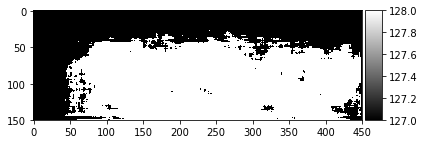

TARGET


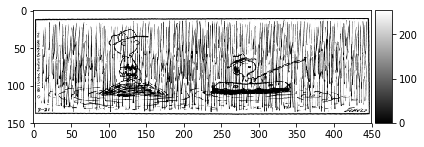

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 0 progress report:
latent shape:  (1, 100)
latent:  [[0.07456109 0.65183929 0.1624296  0.2075003  0.81936692 0.36660945
  0.65680961 0.14169986 0.63836441 0.23288615 0.18823529 0.35233645
  0.96432572 0.58392911 0.84128809 0.11911197 0.78857434 0.77014127
  0.55299181 0.01539934 0.09441573 0.36160294 0.0584696  0.70177156
  0.71660121 0.91986422 0.07050029 0.22938145 0.49675377 0.96648077
  0.28369453 0.55742061 0.86164381 0.06643087 0.36736248 0.18308795
  0.2082167  0.5258366  0.15709637 0.82906743 0.58439574 0.34924247
  0.65905251 0.37660825 0.10155941 0.90258526 0.17182747 0.79510239
  0.75053295 0.55599238 0.32448068 0.14026398 0.36136884 0.10669449
  0.97290571 0.80176647 0.04641608 0.31568728 0.62645515 0.67859862
  0.65879947 0.10973848 0.92752136 0.89208235 0.5818843  0.39608808
  0.29122453 0.68608393 0.01139913 0.70425071 0.52796998 0.92331586
  0.18734742 0.66326324 0.9217024  0.60723613 0.66980345 0.1516341
 

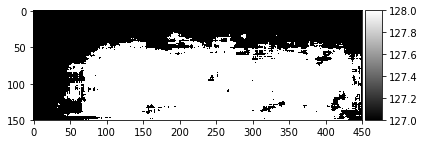

TARGET


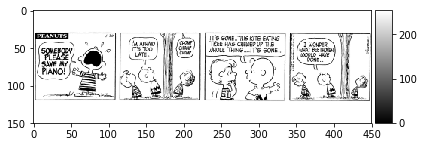

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 1 progress report:
latent shape:  (1, 100)
latent:  [[0.86805722 0.46258597 0.36284176 0.76360877 0.2636078  0.2926139
  0.6008758  0.91576034 0.2743786  0.85310484 0.24082642 0.62195111
  0.31038879 0.00973722 0.42896554 0.74289436 0.39881418 0.3674636
  0.47862531 0.20445141 0.43609814 0.40102663 0.22122799 0.98055556
  0.81009337 0.32823267 0.50775138 0.1657947  0.0352755  0.94186771
  0.57905773 0.71463579 0.01467855 0.31528744 0.96741932 0.89207324
  0.76940714 0.21771442 0.57859971 0.28146804 0.9779592  0.75384627
  0.42815152 0.76410929 0.071636   0.90146729 0.585339   0.36256312
  0.38580304 0.40429199 0.23478537 0.56279419 0.61021439 0.3574689
  0.47100694 0.10625555 0.25848339 0.14705517 0.58969665 0.4318706
  0.12594831 0.40049826 0.55350996 0.94034306 0.50555662 0.15096332
  0.22631508 0.88142075 0.35924281 0.03293521 0.3119809  0.42779112
  0.10206883 0.93721628 0.28267349 0.95702749 0.26135483 0.40963367
  0.

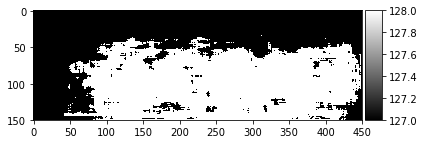

TARGET


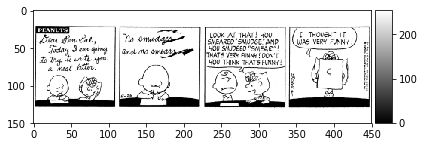

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 2 progress report:
latent shape:  (1, 100)
latent:  [[0.72059239 0.50082322 0.08644027 0.87832182 0.91106374 0.49572473
  0.70614275 0.45864567 0.075475   0.68397631 0.89202596 0.24874477
  0.00916074 0.42740756 0.15755771 0.61117367 0.36248292 0.46702354
  0.70644888 0.04220928 0.13954081 0.8037896  0.85283492 0.58423151
  0.10357364 0.0110432  0.62787937 0.08282229 0.31582976 0.28845771
  0.18287898 0.83177457 0.2296552  0.25356557 0.19686655 0.96551822
  0.79541457 0.62584257 0.74313133 0.76738373 0.41622835 0.77166398
  0.98380504 0.61622015 0.43989516 0.0055968  0.0734506  0.93489756
  0.58452148 0.76587849 0.61764378 0.1479884  0.13268325 0.38374822
  0.25813435 0.54998007 0.3314976  0.99241072 0.56341143 0.19909274
  0.74203686 0.46890148 0.04731939 0.04807562 0.52791846 0.04029874
  0.42541586 0.06538343 0.22269478 0.96930019 0.04609951 0.72525322
  0.43846762 0.78162609 0.56678884 0.13437318 0.91071995 0.25440554


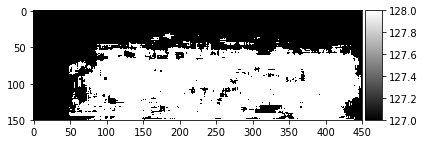

TARGET


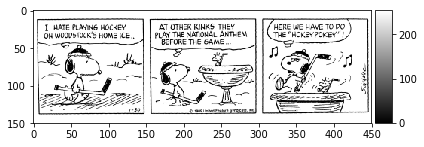

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 3 progress report:
latent shape:  (1, 100)
latent:  [[0.75457328 0.42158855 0.40762742 0.75341659 0.15829971 0.62664945
  0.27785896 0.35900754 0.54220069 0.34856757 0.32740481 0.4131256
  0.92717034 0.49706298 0.17581692 0.66841768 0.44121263 0.84698302
  0.62477232 0.74308051 0.64849454 0.40419771 0.37507971 0.25032135
  0.22551221 0.52383826 0.70851492 0.48840622 0.83514137 0.80005254
  0.74593799 0.34960725 0.91884359 0.11664432 0.25115156 0.53596445
  0.60083987 0.78574484 0.70711028 0.32920796 0.71325793 0.22798198
  0.34725804 0.94890184 0.09470239 0.53611671 0.96062315 0.1990237
  0.11818712 0.12816411 0.65417735 0.20707994 0.0519993  0.3299876
  0.34065384 0.40791318 0.70062995 0.29487829 0.84740705 0.80015014
  0.59270217 0.22161598 0.8546164  0.08612474 0.26326116 0.27091498
  0.69965151 0.54494538 0.84388621 0.98173097 0.81335466 0.79806549
  0.62891962 0.3483959  0.78512929 0.85309574 0.82445287 0.78968545
  0

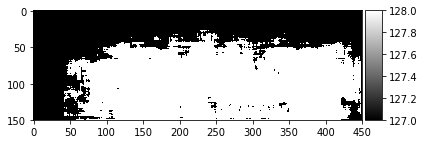

TARGET


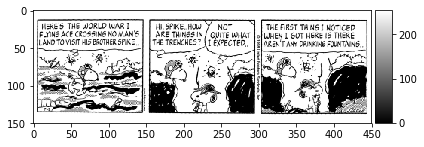

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 4 progress report:
latent shape:  (1, 100)
latent:  [[0.43949478 0.68616849 0.05245751 0.75211622 0.20424555 0.74732128
  0.75841936 0.46980514 0.76515899 0.49845272 0.65017573 0.47667426
  0.5227218  0.45835324 0.66648941 0.46899128 0.85918975 0.95576946
  0.97069614 0.32934165 0.58470843 0.4258638  0.49311059 0.50969534
  0.99749774 0.2133257  0.27051051 0.1430904  0.37113245 0.34139879
  0.34801108 0.51252285 0.15835714 0.88865894 0.32521855 0.41038915
  0.04006982 0.11299081 0.62423047 0.3259496  0.3253163  0.69311329
  0.17245575 0.01792624 0.08544087 0.85477609 0.4294751  0.50615434
  0.17611825 0.38668511 0.87452101 0.20312022 0.89524279 0.70925931
  0.16025523 0.08173603 0.20212127 0.45267571 0.14849412 0.78227021
  0.8809536  0.41535254 0.45044789 0.57075642 0.70456737 0.30180001
  0.86716121 0.40469262 0.1410009  0.26160947 0.0497786  0.67109587
  0.95560712 0.14759524 0.72798718 0.33334442 0.6720615  0.42809847


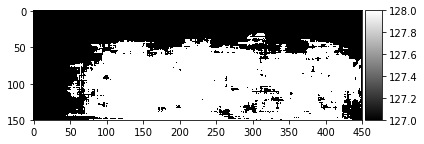

TARGET


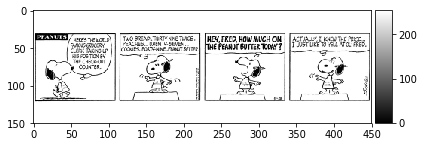

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 5 progress report:
latent shape:  (1, 100)
latent:  [[0.92212866 0.72700682 0.27159639 0.36077308 0.79629812 0.34466305
  0.11806114 0.72445942 0.13458228 0.1608413  0.24893497 0.20597321
  0.42930885 0.93788572 0.1694374  0.12121558 0.85800126 0.08709966
  0.3029342  0.84892391 0.27768388 0.63499975 0.32517897 0.52524301
  0.18290924 0.90047656 0.54574633 0.30894    0.23742196 0.09914214
  0.01944603 0.71518163 0.58692684 0.41292205 0.81242108 0.12064175
  0.18852803 0.40947973 0.53603993 0.45427049 0.62690192 0.78354988
  0.3370824  0.70768856 0.49516832 0.76121307 0.60000224 0.78915779
  0.84918709 0.8112111  0.528507   0.16793677 0.25844062 0.7020928
  0.03997713 0.09017972 0.91806912 0.01260065 0.55059461 0.04038994
  0.27544931 0.27160064 0.80052398 0.96147016 0.92560143 0.89419376
  0.61826691 0.62260075 0.24008003 0.75598148 0.46512415 0.06496527
  0.60409954 0.00714402 0.51296757 0.94744698 0.43126928 0.67642343
 

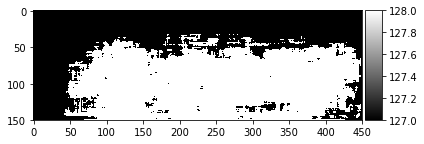

TARGET


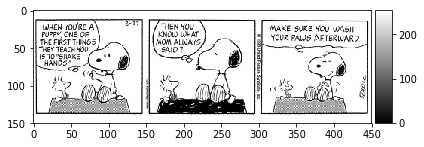

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 6 progress report:
latent shape:  (1, 100)
latent:  [[0.62332511 0.36894161 0.38736735 0.01188898 0.43655131 0.66408711
  0.98265846 0.72125418 0.50297774 0.68706263 0.93339861 0.37505681
  0.46947964 0.84103869 0.06106694 0.22865113 0.90412079 0.82656142
  0.2381981  0.89861391 0.58545708 0.96179342 0.0836677  0.8871889
  0.37566208 0.55554022 0.41726135 0.05787228 0.4613989  0.35102288
  0.74400542 0.21068504 0.92884295 0.93829538 0.07897703 0.69223431
  0.5181358  0.75548109 0.3855655  0.97967899 0.23506787 0.4473272
  0.51746349 0.89078806 0.83603546 0.87945871 0.97323294 0.92502657
  0.74055228 0.91011078 0.39971955 0.00556133 0.25154047 0.99843961
  0.51643347 0.89510044 0.43863179 0.51217216 0.79897668 0.13885885
  0.2068063  0.91758176 0.58498075 0.14865034 0.47533129 0.08990651
  0.83112966 0.96532954 0.98667942 0.02145115 0.99417185 0.77181954
  0.56284972 0.33581774 0.16709876 0.92201637 0.78475479 0.25710519
  

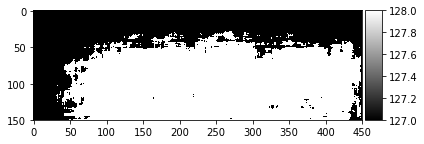

TARGET


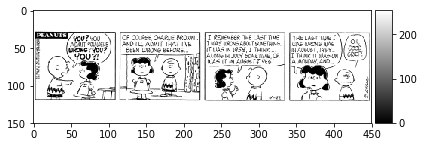

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 7 progress report:
latent shape:  (1, 100)
latent:  [[0.7420925  0.17825018 0.45536709 0.11736151 0.39138393 0.35511896
  0.56422272 0.91970981 0.23468361 0.15041886 0.60621732 0.8821579
  0.05412342 0.87319962 0.41862388 0.19071154 0.15465303 0.67040857
  0.59970322 0.72560279 0.94920966 0.56260267 0.25069619 0.99826938
  0.14963697 0.77974685 0.76438442 0.4273593  0.34284387 0.7844041
  0.48139328 0.28115077 0.46519308 0.3462975  0.51795713 0.39134644
  0.13180427 0.41601999 0.03185551 0.75593833 0.84262455 0.91487988
  0.88630891 0.22340514 0.54183603 0.27871033 0.06965031 0.43606465
  0.8586802  0.18784785 0.47771034 0.02278519 0.90430807 0.31498107
  0.49181994 0.55767501 0.87140368 0.64577042 0.6538007  0.37749302
  0.29491635 0.16836946 0.08469174 0.02385927 0.55406798 0.98052458
  0.25856333 0.31300543 0.00675858 0.049859   0.96123619 0.98175437
  0.04739173 0.18525414 0.57046787 0.75594054 0.28530133 0.15718593
  

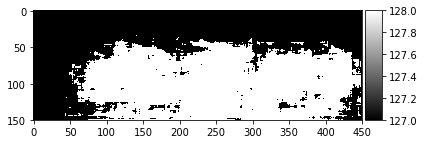

TARGET


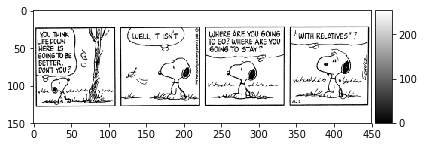

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 8 progress report:
latent shape:  (1, 100)
latent:  [[0.70344394 0.37072478 0.39248169 0.54043375 0.42961971 0.42365061
  0.51359893 0.66653762 0.48017478 0.31455012 0.84351223 0.47339934
  0.01980458 0.85809221 0.0751859  0.89351765 0.94976655 0.85871372
  0.36573404 0.88536665 0.89410736 0.8892216  0.5510219  0.43396774
  0.68759316 0.85145595 0.64620558 0.1507233  0.80841292 0.36802169
  0.46357559 0.91014518 0.4353161  0.09362954 0.46633763 0.15116875
  0.66501659 0.71799197 0.57657098 0.88797731 0.8080383  0.04157947
  0.36875409 0.84202769 0.98658592 0.50526711 0.36882475 0.40297035
  0.3718966  0.69518567 0.9992933  0.89268429 0.85448299 0.73003877
  0.20215506 0.44449685 0.80278321 0.5448485  0.47710498 0.30794818
  0.06823108 0.14899113 0.28580183 0.6160651  0.36639451 0.91033252
  0.98413032 0.19640075 0.21811684 0.8905192  0.54650061 0.02300295
  0.1314792  0.27047471 0.74410813 0.40221066 0.54079948 0.86951368


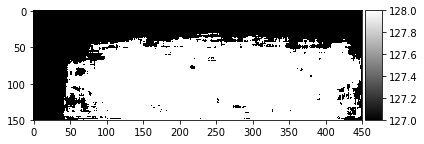

TARGET


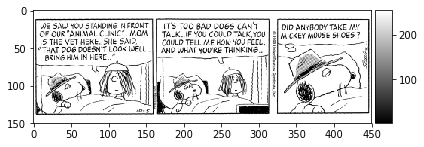

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 9 progress report:
latent shape:  (1, 100)
latent:  [[0.12835669 0.68945069 0.98831665 0.54630029 0.45167734 0.54970656
  0.01623725 0.87364979 0.20282317 0.2222689  0.65668697 0.03784522
  0.46404239 0.88016605 0.66911699 0.90936565 0.70250992 0.33731035
  0.77555231 0.38685393 0.96010813 0.36352703 0.19900025 0.74551269
  0.93616733 0.81254351 0.08806525 0.25395934 0.21129496 0.53514839
  0.21998137 0.94384013 0.65049908 0.79269915 0.98339808 0.30926484
  0.06165802 0.13414482 0.18052783 0.20048766 0.89873574 0.84669754
  0.91718988 0.02748437 0.2258723  0.3140661  0.93379778 0.33883316
  0.94437168 0.06453338 0.89464306 0.97984789 0.05715179 0.75524341
  0.63777912 0.64853414 0.20994042 0.81742571 0.74353386 0.04951891
  0.50191998 0.63160715 0.97844703 0.12829198 0.47468613 0.50840231
  0.35539522 0.02808675 0.53211188 0.15821514 0.5451234  0.46352156
  0.53452159 0.0454965  0.42307235 0.76434584 0.2258108  0.49124349


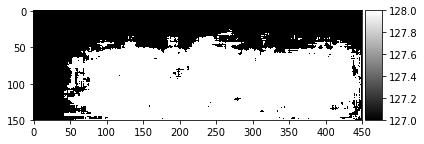

TARGET


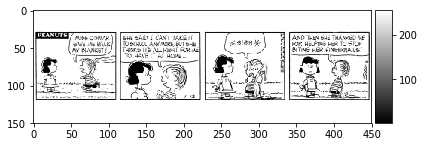

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 10 progress report:
latent shape:  (1, 100)
latent:  [[0.60586661 0.5870793  0.65359917 0.71876024 0.32244211 0.73709413
  0.18777395 0.24775992 0.58738577 0.22226572 0.06861582 0.62314462
  0.39323812 0.64442026 0.82085453 0.59931921 0.38410788 0.21612051
  0.88267095 0.25971956 0.14674433 0.93763245 0.38848861 0.86502326
  0.10356353 0.15500248 0.93458725 0.65372783 0.43234761 0.53648513
  0.3817701  0.11119332 0.0275711  0.33344928 0.35869947 0.0085424
  0.1771253  0.41735379 0.15690496 0.96809268 0.6250302  0.85568234
  0.87419239 0.54704536 0.28932743 0.63000662 0.58117723 0.14715998
  0.91043205 0.07834372 0.40973405 0.47655627 0.40252674 0.49718474
  0.34666702 0.29706057 0.84261617 0.59012593 0.04371479 0.98045809
  0.07142155 0.49669468 0.71754861 0.01119898 0.04453284 0.87478782
  0.53194352 0.42424244 0.3203799  0.98569158 0.33774937 0.86743645
  0.93023202 0.01346568 0.22576549 0.69704987 0.30393126 0.57199799


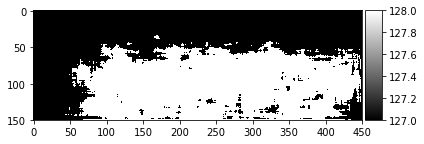

TARGET


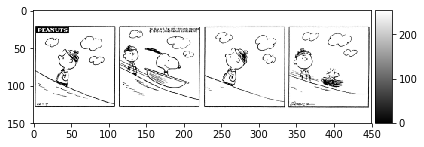

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 11 progress report:
latent shape:  (1, 100)
latent:  [[0.34848026 0.08258978 0.38816187 0.26614655 0.92802089 0.25079467
  0.69485142 0.23789943 0.410993   0.72563889 0.83086776 0.01709499
  0.67378416 0.19376085 0.91235342 0.9828021  0.54870963 0.58107437
  0.94798424 0.96891178 0.33953132 0.90183861 0.70773908 0.90486976
  0.22359686 0.0543733  0.50104817 0.54578947 0.44605344 0.22134544
  0.39212574 0.11687117 0.761782   0.81758097 0.43065544 0.23589859
  0.26294356 0.5260349  0.26340477 0.66593202 0.78296639 0.35679307
  0.63881401 0.04718261 0.04462131 0.96188739 0.50035205 0.13237861
  0.64717565 0.67707924 0.85031259 0.76754993 0.05894174 0.35362129
  0.39773587 0.31098305 0.51635261 0.67360866 0.81731331 0.84094239
  0.6677559  0.48797002 0.69477848 0.76810615 0.58720419 0.78740935
  0.25733337 0.66509976 0.94365466 0.40258909 0.22554047 0.59068728
  0.86133586 0.80972082 0.32914668 0.22171286 0.38953927 0.94063527

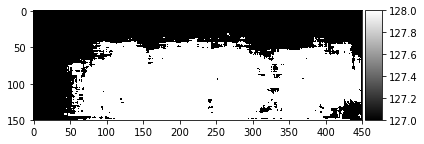

TARGET


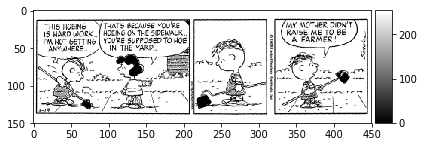

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 12 progress report:
latent shape:  (1, 100)
latent:  [[0.55086684 0.05658182 0.73064959 0.12971269 0.38620453 0.79410334
  0.92984341 0.20884515 0.88740779 0.82194806 0.55043355 0.19419169
  0.64732385 0.59102984 0.70764928 0.02750642 0.9484564  0.76014573
  0.81132537 0.22044508 0.93398396 0.65669279 0.10372314 0.17779055
  0.53521975 0.88145208 0.93735147 0.43946021 0.9684092  0.93786071
  0.68743215 0.25873773 0.63314201 0.06771353 0.70641708 0.13306132
  0.06756922 0.52354168 0.50419618 0.25467338 0.7833617  0.35087453
  0.09988861 0.72951914 0.04464073 0.540318   0.91294831 0.28652507
  0.17681745 0.26903764 0.34854411 0.05165474 0.34175419 0.6218655
  0.86792043 0.57418329 0.926511   0.73522416 0.14026013 0.29572109
  0.6671988  0.72942349 0.0304633  0.99631029 0.74902697 0.27495904
  0.50965674 0.45986086 0.54078941 0.40136996 0.2308034  0.51387711
  0.84708432 0.02743796 0.95867681 0.98477521 0.80419927 0.43253065


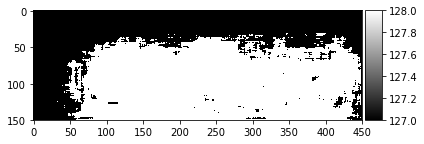

TARGET


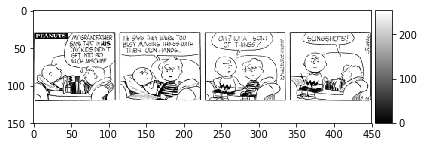

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 13 progress report:
latent shape:  (1, 100)
latent:  [[0.00152709 0.81573514 0.68798584 0.77901758 0.18050409 0.34186928
  0.90088289 0.49995669 0.69769681 0.54731715 0.19778758 0.56682815
  0.56262345 0.31565237 0.58043741 0.39018142 0.88005468 0.83466054
  0.30413537 0.71648766 0.50652812 0.58208652 0.88255092 0.75986667
  0.20993727 0.94418787 0.11949891 0.62606477 0.42259672 0.76121437
  0.979906   0.05973503 0.7480163  0.51401945 0.28384108 0.3287006
  0.28236753 0.08860716 0.86537625 0.07322982 0.96250128 0.58709495
  0.79464709 0.01236947 0.20045216 0.58846298 0.04125383 0.59734944
  0.36367172 0.03094089 0.3915692  0.94177889 0.27097759 0.60562284
  0.76132462 0.32595797 0.43657108 0.3355757  0.02533916 0.87514684
  0.08346574 0.90225057 0.70868803 0.51461539 0.25643212 0.24245546
  0.67518855 0.14448854 0.14741243 0.38135558 0.61174045 0.64163626
  0.60982941 0.37254591 0.09820507 0.78809308 0.72592603 0.19580235


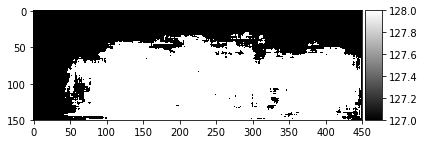

TARGET


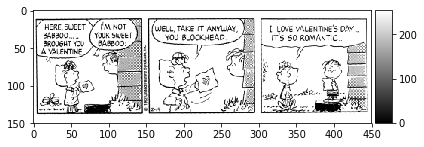

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 14 progress report:
latent shape:  (1, 100)
latent:  [[0.62714236 0.86605866 0.07952358 0.60394105 0.16331227 0.93312349
  0.54973371 0.60930267 0.47638089 0.6724572  0.66640656 0.30192152
  0.1141534  0.97858009 0.64156134 0.81166283 0.56984061 0.33303388
  0.77153192 0.8101873  0.9067805  0.59494886 0.37224397 0.70506522
  0.84806613 0.61489429 0.44219309 0.29517938 0.58339791 0.89361586
  0.89528956 0.75897236 0.54875222 0.16055476 0.26088952 0.754815
  0.24577261 0.6836131  0.96086171 0.60608014 0.83458839 0.28768998
  0.22088005 0.70729703 0.36744761 0.789348   0.96311948 0.45595476
  0.30663336 0.81135884 0.02803619 0.42513629 0.79403719 0.58799453
  0.83716028 0.34763274 0.44853094 0.62455792 0.61689942 0.0971392
  0.31457178 0.89688715 0.07612743 0.4174753  0.21780254 0.68220276
  0.89999484 0.98426095 0.94875622 0.55216504 0.30668144 0.2414084
  0.27653272 0.50521843 0.46981654 0.81491157 0.34496908 0.16752553
  0

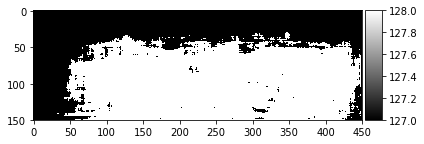

TARGET


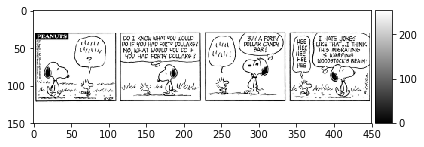

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 15 progress report:
latent shape:  (1, 100)
latent:  [[0.63437715 0.49777416 0.00157153 0.34760912 0.90521927 0.06855295
  0.30417186 0.83431194 0.97349813 0.065915   0.76686629 0.47219692
  0.04448057 0.97640994 0.68042657 0.90753509 0.4442581  0.16423749
  0.4067187  0.71828475 0.92969892 0.01809678 0.76348754 0.8100873
  0.45580215 0.76312026 0.21285369 0.3962062  0.01141701 0.75817585
  0.09223282 0.83153395 0.29225517 0.9392916  0.30627151 0.45634377
  0.97875675 0.67767511 0.68157445 0.46906292 0.00720395 0.68122121
  0.052854   0.18776772 0.71750702 0.38380637 0.69206335 0.64223169
  0.82397694 0.95919346 0.47784046 0.34793264 0.83875766 0.38154715
  0.26120634 0.87016791 0.68261196 0.67649189 0.00445109 0.13419491
  0.60972576 0.75491089 0.608582   0.28463683 0.62534492 0.61195939
  0.6042983  0.07268261 0.63021103 0.93365611 0.42132257 0.30788717
  0.6880988  0.74236037 0.32453865 0.64438129 0.60627418 0.20502825


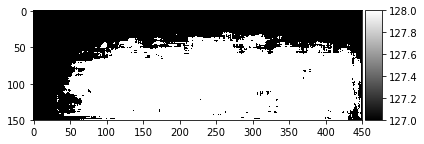

TARGET


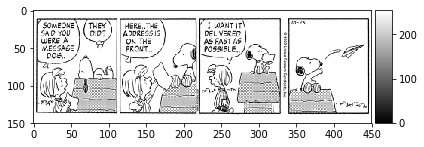

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 16 progress report:
latent shape:  (1, 100)
latent:  [[6.68464007e-01 9.93980941e-01 1.54352552e-01 6.38014877e-02
  3.05799263e-02 8.82188162e-02 9.99441499e-01 5.20890673e-01
  8.01263877e-01 4.02217553e-01 5.66587661e-01 2.57577827e-01
  7.05557305e-01 5.40040755e-01 3.79608625e-01 5.01981211e-01
  4.55224022e-01 3.30533240e-01 2.29093625e-02 7.68786280e-01
  3.14650586e-01 8.73190196e-01 8.46172809e-01 7.57024511e-01
  4.16521328e-01 8.88079901e-01 9.75255791e-01 9.94478634e-01
  4.90405167e-04 1.06167322e-01 1.02622724e-01 1.61050484e-01
  1.33168189e-02 1.23120632e-02 6.79571254e-01 7.38732779e-01
  8.23151517e-01 7.03744472e-01 4.62464412e-01 4.96090274e-01
  4.24431225e-02 7.11178403e-01 8.69519936e-01 7.53919614e-01
  5.39754806e-01 9.17523384e-01 8.73353078e-01 1.08752189e-01
  7.76680523e-01 2.74383071e-01 3.70510834e-01 6.56502270e-01
  5.64215829e-01 7.86967504e-01 6.08477136e-01 5.27264769e-01
  8.16879888e-0

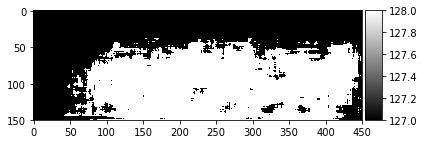

TARGET


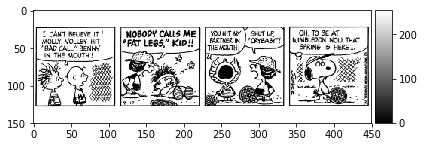

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 17 progress report:
latent shape:  (1, 100)
latent:  [[0.68249192 0.65589323 0.18119743 0.87467277 0.78643036 0.60861773
  0.23221294 0.14299576 0.16546558 0.79835789 0.10477884 0.965777
  0.58905189 0.55206507 0.41507737 0.65694168 0.54359167 0.53637497
  0.48624625 0.12146391 0.9759925  0.48175075 0.17500135 0.97159584
  0.31619151 0.9930847  0.78952187 0.17493498 0.40194012 0.72051662
  0.08476273 0.0427727  0.86002402 0.23189107 0.32299055 0.88281072
  0.84041209 0.2240066  0.11434231 0.23973133 0.1172656  0.36415241
  0.60957773 0.15142131 0.67181024 0.86553221 0.80738038 0.53346106
  0.54239285 0.69950207 0.1581357  0.63625442 0.29172249 0.75793341
  0.25327879 0.54894787 0.50863082 0.37368601 0.0531643  0.55118382
  0.23867497 0.61861153 0.5691277  0.2556897  0.60292997 0.73306667
  0.96795734 0.85408803 0.48121242 0.95042088 0.0864492  0.79674527
  0.21498768 0.46309686 0.28046457 0.00660181 0.51544415 0.89296854
 

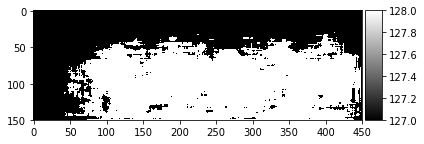

TARGET


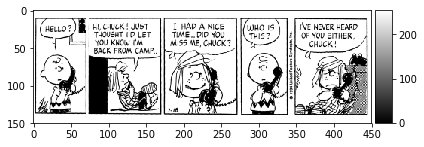

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 18 progress report:
latent shape:  (1, 100)
latent:  [[0.01792988 0.16657307 0.5487941  0.4659392  0.85652753 0.52474506
  0.30098563 0.58618099 0.78101448 0.9347946  0.0319066  0.23402248
  0.42690394 0.4706669  0.18802292 0.42219094 0.0701036  0.8105036
  0.24277241 0.67816616 0.90442122 0.86631866 0.55120841 0.61065269
  0.40924547 0.66719633 0.78218055 0.24790054 0.60580526 0.17118575
  0.94043556 0.40456538 0.94832173 0.86562854 0.72180941 0.47511246
  0.7206294  0.54894713 0.21723499 0.54906312 0.82808564 0.39558032
  0.05746356 0.99448767 0.71639279 0.63866561 0.55353799 0.41833976
  0.18855333 0.95425536 0.47365257 0.53020592 0.20757334 0.63307619
  0.47990456 0.26707876 0.45147093 0.56718511 0.77663483 0.16109308
  0.08755002 0.0897941  0.36592529 0.40271647 0.33581045 0.65349423
  0.42817988 0.40941037 0.03582209 0.31026333 0.9086341  0.97964988
  0.17250879 0.84601281 0.71753061 0.69865298 0.5644739  0.76062482


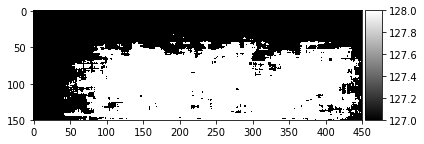

TARGET


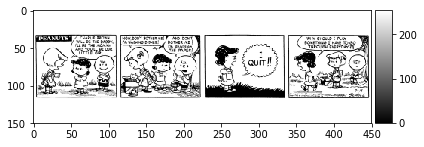

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 19 progress report:
latent shape:  (1, 100)
latent:  [[0.10346468 0.29182404 0.9336372  0.8678046  0.24510907 0.727618
  0.24726593 0.2616761  0.22923758 0.64380308 0.64777993 0.2739505
  0.33073204 0.42368235 0.522508   0.75670362 0.40233152 0.22816671
  0.04632918 0.46383114 0.41724391 0.5432846  0.41695561 0.80678037
  0.96444697 0.3608407  0.03616571 0.7559848  0.7710073  0.18079627
  0.09474141 0.64641309 0.76628441 0.8757087  0.94528514 0.29545829
  0.37456852 0.40645613 0.42832174 0.24873265 0.96915277 0.87556512
  0.85954585 0.04866429 0.52571837 0.4888163  0.83629194 0.97994893
  0.65502193 0.11023077 0.42121714 0.79586568 0.41187023 0.7650662
  0.46582732 0.27873725 0.16501137 0.50064446 0.30735516 0.22320529
  0.2606949  0.95480994 0.45894832 0.12797488 0.80667817 0.25973434
  0.58811507 0.11478312 0.31641941 0.3659351  0.83705386 0.80613131
  0.01355848 0.53986637 0.26050991 0.6270145  0.54063745 0.30935215
  0

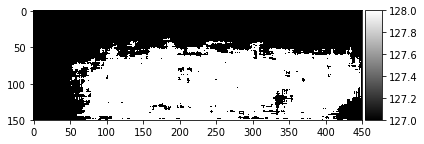

TARGET


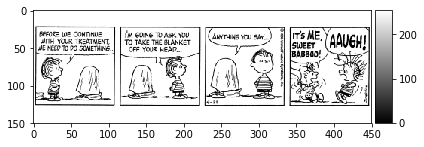

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 20 progress report:
latent shape:  (1, 100)
latent:  [[0.0892014  0.4645552  0.09192567 0.11893343 0.79786856 0.85102181
  0.56446827 0.17460374 0.16706538 0.65057298 0.01717501 0.81357273
  0.92430097 0.29045543 0.29477564 0.2672359  0.91738632 0.07608243
  0.63703809 0.03504529 0.32829426 0.52726444 0.95294189 0.90407555
  0.60551963 0.17406642 0.32172813 0.01340015 0.56962675 0.47252372
  0.92987959 0.0880424  0.75294886 0.77546451 0.62530045 0.14147218
  0.29297624 0.55323367 0.25784759 0.24051078 0.08479501 0.30400785
  0.45599947 0.95187266 0.09856801 0.25879147 0.87723693 0.54178757
  0.05802543 0.48381216 0.90505583 0.61055446 0.30179182 0.59408575
  0.53160472 0.29666734 0.56933547 0.0820936  0.7943207  0.47712047
  0.73701985 0.80221087 0.75968802 0.80964725 0.80831271 0.8601355
  0.45818542 0.13057086 0.67982764 0.11250418 0.20164241 0.78907921
  0.95992229 0.40644578 0.28609727 0.15747606 0.68512365 0.13814361


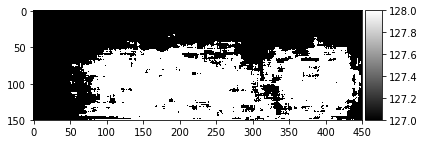

TARGET


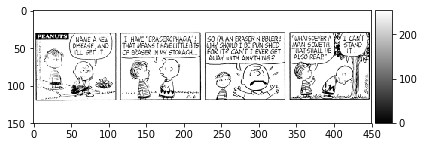

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 21 progress report:
latent shape:  (1, 100)
latent:  [[0.74142181 0.42514254 0.86084261 0.86667158 0.52479914 0.79537106
  0.10654187 0.28297822 0.01444132 0.29004125 0.35051724 0.90234516
  0.79029063 0.73704912 0.38750839 0.3090975  0.96568016 0.92080383
  0.6640056  0.89261856 0.73106505 0.91104255 0.75096026 0.05769535
  0.03784338 0.01263926 0.87645677 0.29687376 0.28861006 0.67233849
  0.52984996 0.79181773 0.20186932 0.18506755 0.45266837 0.67461203
  0.45481616 0.47140951 0.33659167 0.85025659 0.39876162 0.47098684
  0.73745844 0.30125999 0.00239195 0.22998422 0.01566762 0.78042324
  0.05990129 0.06826444 0.32842705 0.22315352 0.19020291 0.15645858
  0.35368658 0.50614633 0.31727466 0.77501783 0.78292482 0.27534763
  0.75223247 0.76991098 0.67201403 0.29026949 0.59319225 0.73381608
  0.21369413 0.29141562 0.69364768 0.70470774 0.48791811 0.36468524
  0.74765082 0.46843867 0.72105134 0.28762793 0.24634456 0.19819304

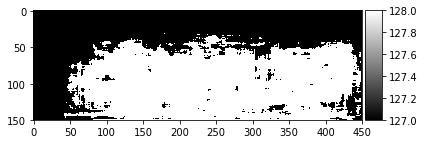

TARGET


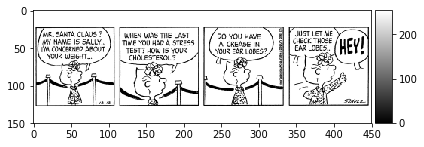

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 22 progress report:
latent shape:  (1, 100)
latent:  [[0.97237876 0.04818169 0.8653673  0.74682262 0.74303525 0.23885835
  0.05898695 0.60692098 0.27022891 0.69975757 0.67924955 0.75875232
  0.9997349  0.16784046 0.07880246 0.97268918 0.45690823 0.09373411
  0.08141601 0.49410053 0.33630658 0.67806414 0.51240057 0.80009548
  0.87198485 0.43337185 0.58633343 0.11269917 0.17698488 0.12453901
  0.23486686 0.75434313 0.45939236 0.48633049 0.56946687 0.81566931
  0.33796316 0.70223345 0.64263821 0.51853689 0.70005536 0.17597788
  0.06011567 0.86136192 0.18296091 0.54109936 0.9633232  0.29490705
  0.93702121 0.38830674 0.1666482  0.93079114 0.17013062 0.64635611
  0.51936152 0.63434149 0.88704482 0.33068163 0.31852181 0.29045455
  0.10148629 0.99770683 0.73608426 0.5091272  0.35846521 0.00515325
  0.20544411 0.33996718 0.06731455 0.83203889 0.54728716 0.26874059
  0.36299326 0.8076152  0.05571767 0.14068212 0.54907164 0.81648844

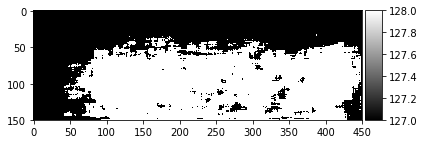

TARGET


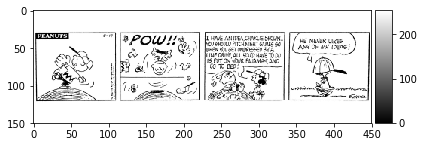

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 23 progress report:
latent shape:  (1, 100)
latent:  [[0.01849079 0.04274852 0.68301892 0.5536379  0.05678252 0.35594144
  0.48412355 0.48044589 0.16775715 0.83371836 0.13772152 0.56176206
  0.93405203 0.17006338 0.90355494 0.46556577 0.54775891 0.09839701
  0.66537739 0.87894684 0.99108909 0.06302422 0.82112281 0.52024577
  0.32252402 0.36146783 0.60034617 0.45311688 0.10989375 0.72259701
  0.41805291 0.10194899 0.32037107 0.13942824 0.81233494 0.8986331
  0.42878101 0.99209695 0.60792616 0.70917239 0.45948941 0.14032459
  0.30847365 0.55790733 0.65595881 0.27582263 0.80318517 0.82232591
  0.86999995 0.30157664 0.96146534 0.26875195 0.09391713 0.02933782
  0.76086194 0.66360578 0.25274908 0.88055038 0.60394543 0.29153863
  0.58346746 0.00867714 0.82151766 0.09268094 0.03431175 0.85048404
  0.36395979 0.31293358 0.3527558  0.39735309 0.78282832 0.6161674
  0.42798792 0.83743041 0.92955019 0.46404941 0.21211256 0.86615762
 

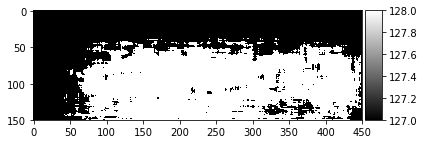

TARGET


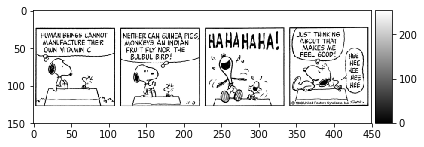

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 24 progress report:
latent shape:  (1, 100)
latent:  [[0.92081188 0.25224354 0.48908372 0.86338972 0.02269353 0.62906813
  0.76526323 0.67017428 0.05506561 0.09790579 0.54868163 0.29190362
  0.98806212 0.3882406  0.94692254 0.51198819 0.39124903 0.49274966
  0.40857634 0.34046397 0.47016577 0.85996899 0.54010417 0.36109509
  0.66905775 0.53051684 0.50529047 0.07952851 0.17500442 0.48816472
  0.99802325 0.86827529 0.18441191 0.71078556 0.5746011  0.48466188
  0.77998458 0.31533955 0.77223789 0.44450643 0.21277271 0.79079306
  0.49357293 0.80577063 0.06667432 0.41100212 0.94155447 0.19368581
  0.96949214 0.9270545  0.5892702  0.18852865 0.78791935 0.03770794
  0.47281586 0.20451059 0.27350889 0.57715481 0.95148333 0.83087286
  0.10593078 0.74357494 0.92818305 0.49295248 0.20610056 0.98294776
  0.29251584 0.52444453 0.10467809 0.68537023 0.48414644 0.02733599
  0.24741727 0.79326614 0.8385258  0.34140681 0.34698912 0.78115291

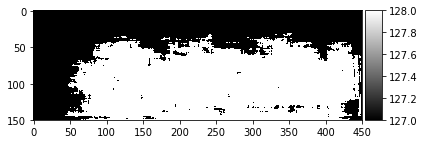

TARGET


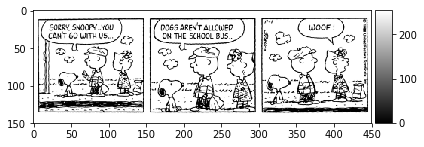

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 25 progress report:
latent shape:  (1, 100)
latent:  [[0.17645161 0.38188921 0.46531143 0.89623423 0.03496436 0.80323202
  0.76152775 0.69699287 0.62931971 0.4326589  0.10342864 0.81661705
  0.37215857 0.37921786 0.47942099 0.2699635  0.17287847 0.50297634
  0.76267497 0.46979473 0.19901247 0.44643825 0.61402788 0.98780348
  0.25799963 0.14208158 0.47557395 0.89139681 0.59878591 0.97701852
  0.24747242 0.8074091  0.4686215  0.94749274 0.52174784 0.65712984
  0.00572185 0.78639197 0.34520946 0.36622826 0.2108703  0.44024918
  0.42545802 0.75939741 0.19494118 0.11752704 0.63772907 0.47692461
  0.43299871 0.53273339 0.35989516 0.41711499 0.75159471 0.25166746
  0.01965538 0.39585218 0.58598558 0.48249693 0.69076459 0.96434578
  0.33287539 0.60690395 0.47940263 0.67457188 0.25231074 0.01207835
  0.34222702 0.98364246 0.2014529  0.36901985 0.54783742 0.15794868
  0.51908344 0.39429029 0.93488834 0.77448747 0.55091693 0.06941796

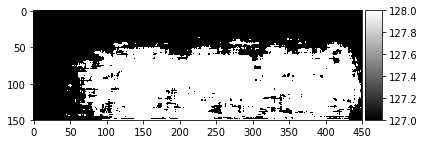

TARGET


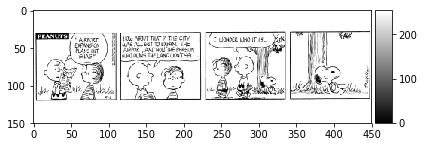

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 26 progress report:
latent shape:  (1, 100)
latent:  [[0.78078865 0.32689005 0.43960218 0.46094036 0.92875207 0.55552347
  0.25367135 0.93033421 0.28957749 0.92585707 0.48918411 0.94933784
  0.80814904 0.66056236 0.06254688 0.19722009 0.20480293 0.5291996
  0.3595887  0.39020761 0.72019343 0.82186801 0.88248475 0.9669944
  0.89135818 0.18897053 0.28535965 0.88133646 0.69400596 0.02297814
  0.63422858 0.34478507 0.52741358 0.38415914 0.53820467 0.86155387
  0.90709121 0.71023817 0.91979664 0.70058036 0.28151361 0.68671426
  0.91015193 0.89147158 0.14841992 0.666888   0.72319117 0.55733222
  0.02224604 0.98302621 0.35077509 0.05400806 0.85188414 0.56260407
  0.76313096 0.98653688 0.65688168 0.36015517 0.04491142 0.26866478
  0.65678429 0.3417302  0.03471077 0.93521495 0.69849515 0.58263827
  0.97532822 0.0544336  0.21952983 0.04815294 0.90843811 0.73021681
  0.23473842 0.42297603 0.74274703 0.84948382 0.19633763 0.24044027
 

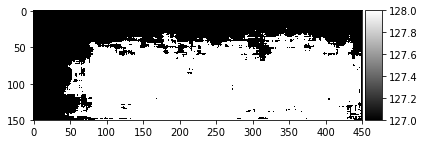

TARGET


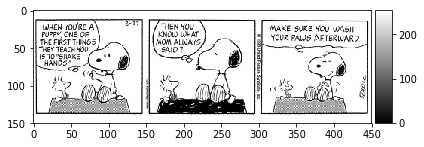

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 27 progress report:
latent shape:  (1, 100)
latent:  [[0.33361091 0.96039545 0.09079107 0.83736038 0.49467588 0.87315447
  0.86500549 0.18704523 0.11162673 0.00604458 0.99645117 0.27858679
  0.74653436 0.83832739 0.27199477 0.83070631 0.08272509 0.18246341
  0.40060217 0.6449992  0.67295586 0.69215898 0.30872915 0.18895274
  0.23281587 0.7981826  0.67136728 0.14590617 0.92337144 0.40096947
  0.81974699 0.31551071 0.76276213 0.72016395 0.52640102 0.95504895
  0.1530027  0.83386902 0.36671575 0.93866509 0.35166921 0.75652776
  0.87738125 0.8338829  0.39083448 0.3686548  0.71567858 0.73955918
  0.21338897 0.66965908 0.42775422 0.27299489 0.87310481 0.51083493
  0.12028301 0.22840367 0.19489878 0.00421541 0.38385548 0.4197993
  0.18107175 0.47969277 0.8960331  0.9601235  0.23589271 0.55322823
  0.74953555 0.33305736 0.78860203 0.99101287 0.46660925 0.25161183
  0.78813629 0.48845037 0.61650235 0.24122138 0.16084834 0.46663389


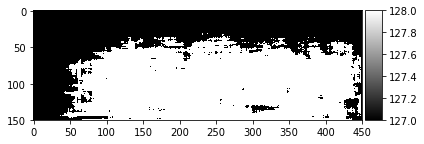

TARGET


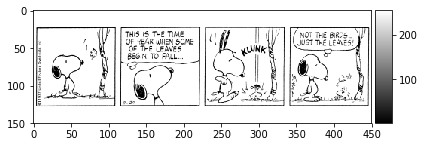

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 28 progress report:
latent shape:  (1, 100)
latent:  [[0.52294733 0.54938235 0.68956835 0.98133465 0.95915732 0.77401284
  0.51384766 0.55869069 0.56804233 0.98580746 0.49816895 0.16749835
  0.17555568 0.5766253  0.19654384 0.9456461  0.01229023 0.81181638
  0.32674439 0.99990275 0.15835483 0.3107621  0.25726792 0.93989863
  0.41649208 0.68381488 0.69559508 0.94407047 0.35878057 0.24003153
  0.34265992 0.14453245 0.08465101 0.58097933 0.98080979 0.08720046
  0.26167908 0.17499706 0.21727052 0.68855669 0.74277631 0.30039344
  0.97692944 0.18154126 0.43962105 0.48207156 0.89586603 0.93373436
  0.47677978 0.1736369  0.55214671 0.81129562 0.13062341 0.41874188
  0.58100581 0.4296258  0.24424483 0.67717642 0.35106807 0.73532798
  0.83100101 0.07693251 0.34614895 0.89377974 0.68000891 0.01453005
  0.87322105 0.47290183 0.27346296 0.77305518 0.42654623 0.5308457
  0.92632182 0.52442778 0.05201704 0.65638844 0.14695468 0.06769632


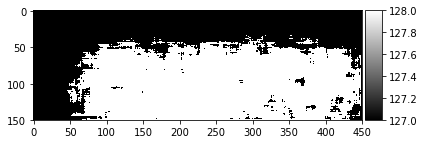

TARGET


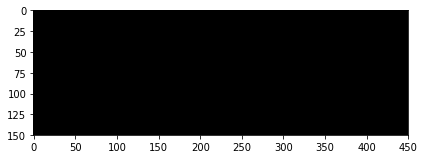

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 29 progress report:
latent shape:  (1, 100)
latent:  [[0.966369   0.58972557 0.66618573 0.80114997 0.89448137 0.08361665
  0.45864347 0.99169074 0.85752266 0.00617276 0.12440948 0.89063681
  0.69984428 0.7459139  0.59909556 0.23656026 0.50074097 0.52959489
  0.6873679  0.62022476 0.92205378 0.99631183 0.97441803 0.15744039
  0.23379026 0.23567558 0.23418211 0.79212176 0.12508713 0.04622787
  0.801868   0.59737329 0.27781341 0.52421787 0.31815045 0.8854997
  0.05646927 0.55682095 0.69070314 0.94087762 0.22024163 0.18391161
  0.2891579  0.34539743 0.8792466  0.36220588 0.26035816 0.76996525
  0.66524047 0.17293595 0.45384995 0.63147361 0.37995464 0.45333981
  0.97265888 0.86196236 0.37179366 0.8245797  0.54696338 0.17871163
  0.79782688 0.16473005 0.29762108 0.30099884 0.03293336 0.31872886
  0.50952394 0.48280907 0.56596538 0.16418925 0.33034477 0.3330719
  0.87251623 0.41881664 0.20818953 0.09608148 0.12255192 0.68957681
 

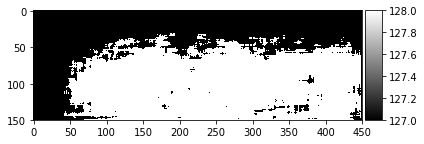

TARGET


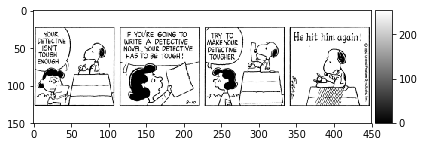

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 30 progress report:
latent shape:  (1, 100)
latent:  [[0.3935936  0.75991034 0.35485311 0.70255488 0.41797011 0.85255474
  0.14366215 0.21055412 0.16455636 0.33280776 0.60835993 0.31675361
  0.26701648 0.36590631 0.42718296 0.32626875 0.91907948 0.12209257
  0.9560001  0.67327694 0.25409047 0.8152446  0.18694762 0.63996933
  0.91037759 0.42121436 0.16968388 0.65272339 0.56821032 0.73933438
  0.32080431 0.81015436 0.51099452 0.52742652 0.58723888 0.40613526
  0.58832005 0.12635468 0.51332873 0.576911   0.61245296 0.38489439
  0.90345339 0.79495348 0.20750307 0.06458727 0.68274067 0.15523276
  0.09228545 0.09690399 0.23144396 0.24128364 0.52456453 0.39715841
  0.36677536 0.66183217 0.56358561 0.1356316  0.40327479 0.04742893
  0.17217568 0.11260393 0.46246348 0.23123628 0.52608308 0.37828689
  0.14257898 0.02067854 0.55876689 0.5371225  0.04812508 0.66509618
  0.63515811 0.11485102 0.90908334 0.02069723 0.42761952 0.50311863

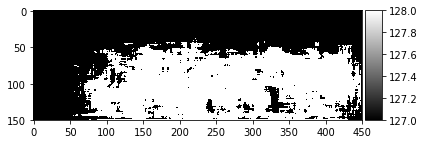

TARGET


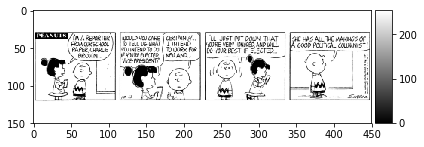

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 31 progress report:
latent shape:  (1, 100)
latent:  [[0.45395691 0.12207597 0.45484016 0.6750821  0.58112868 0.35100839
  0.49087618 0.26527662 0.72937684 0.58979567 0.45564999 0.20736143
  0.98528747 0.80514106 0.08330213 0.00348962 0.02346234 0.95966576
  0.97826386 0.95322233 0.87232759 0.48979505 0.94172616 0.00728262
  0.1527385  0.14536777 0.88668683 0.94405976 0.29235263 0.88327052
  0.60988012 0.91950109 0.23877072 0.41026683 0.58640072 0.49656811
  0.93910056 0.85403677 0.07671497 0.26658653 0.83219346 0.87976167
  0.91856634 0.32090591 0.13461105 0.23761802 0.19954382 0.36180905
  0.27613082 0.46883694 0.30446524 0.88806598 0.97711237 0.88040843
  0.79370836 0.27634843 0.77550562 0.50833258 0.30598596 0.81709626
  0.01344676 0.86720872 0.37165654 0.40791758 0.27179735 0.57663895
  0.33803762 0.09733346 0.43007644 0.51556964 0.5976229  0.85420341
  0.94232742 0.61723803 0.01247058 0.23343946 0.9541935  0.23407796

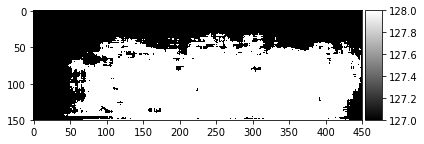

TARGET


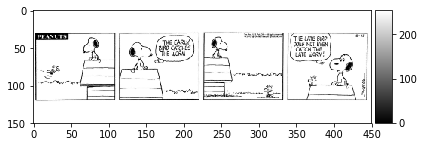

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 32 progress report:
latent shape:  (1, 100)
latent:  [[0.62619517 0.82645454 0.17846796 0.03407536 0.17737743 0.2043687
  0.13894427 0.70892845 0.32792498 0.42020909 0.26832116 0.64996151
  0.8250731  0.05201175 0.48620403 0.62040328 0.58764081 0.39201488
  0.44524214 0.20896169 0.69011094 0.31391459 0.27397575 0.87272936
  0.18909678 0.07905981 0.45022275 0.14787299 0.23327672 0.5139613
  0.06007324 0.49782026 0.19643223 0.71306    0.24456762 0.77341348
  0.28266325 0.7006797  0.77751271 0.19786207 0.46629788 0.57451602
  0.0237095  0.68991793 0.44512657 0.88661147 0.11530282 0.69365271
  0.79788643 0.60257486 0.32465175 0.81817622 0.92214414 0.74741807
  0.35115072 0.78422366 0.17107627 0.22508626 0.1088568  0.48757313
  0.03675997 0.76363158 0.06798681 0.95379528 0.49451578 0.23788423
  0.10788949 0.68218348 0.47665801 0.3461643  0.64449479 0.68976052
  0.57030317 0.09380783 0.88254151 0.14736322 0.52616798 0.76216402
 

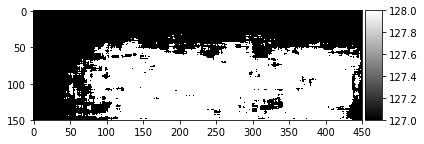

TARGET


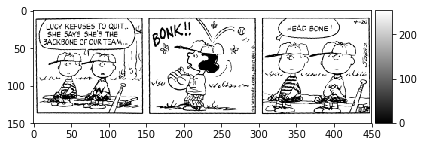

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 33 progress report:
latent shape:  (1, 100)
latent:  [[8.69676576e-01 1.90749163e-02 2.91970421e-01 4.54912040e-01
  4.38982829e-04 7.05032326e-01 2.75383085e-01 6.20117460e-01
  7.90062492e-01 4.69636803e-01 5.06453657e-01 7.20768473e-02
  3.89413812e-01 1.49251914e-01 6.48230903e-01 5.29980869e-01
  4.66692659e-01 4.02525713e-01 8.67778178e-01 5.51359683e-01
  5.41803756e-01 7.45854807e-01 1.94111014e-01 2.51947744e-01
  2.10111031e-01 6.98150961e-01 5.76797942e-01 5.71747954e-01
  3.38294167e-01 4.09217734e-01 3.01964659e-01 7.00290404e-01
  5.76721798e-01 6.15604567e-01 8.83300444e-01 1.15145036e-01
  1.16407464e-01 8.60078208e-01 2.38280747e-01 1.25149107e-01
  5.71728397e-01 5.96351965e-01 5.77809815e-01 8.91570129e-01
  1.08754466e-01 2.68103316e-01 9.66507915e-01 4.97758881e-01
  8.48877271e-01 2.17401371e-01 3.70949679e-01 1.37602836e-01
  4.57165613e-01 2.37592467e-01 4.48714788e-01 5.09161352e-01
  9.97661324e-0

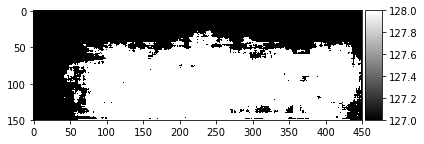

TARGET


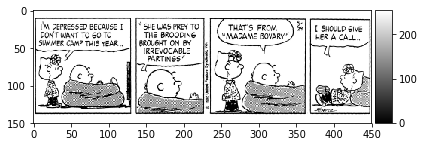

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 34 progress report:
latent shape:  (1, 100)
latent:  [[0.65747469 0.88553798 0.82748841 0.37537326 0.95252112 0.32259384
  0.6884433  0.29652357 0.27068514 0.07935891 0.20063102 0.75663829
  0.91248122 0.04444594 0.68428987 0.42935464 0.75734336 0.29779155
  0.39338468 0.497977   0.58701962 0.40512407 0.09454595 0.48459648
  0.64066267 0.98573874 0.03911534 0.87303066 0.00690229 0.80836722
  0.79235271 0.51068645 0.64990845 0.68344007 0.63616049 0.48569403
  0.289517   0.49759068 0.18094246 0.17689526 0.14978239 0.71512557
  0.69905136 0.82510517 0.94944366 0.00107824 0.52051116 0.00709206
  0.70392796 0.97515129 0.28860485 0.68507687 0.404438   0.04323046
  0.99693549 0.52711925 0.03390705 0.72986291 0.3120221  0.35266371
  0.18723015 0.88582715 0.74196073 0.24546959 0.00762543 0.16360866
  0.76606519 0.59243279 0.97052028 0.71854093 0.89273208 0.99195853
  0.87664552 0.95911899 0.56297857 0.29373931 0.65486472 0.58119136

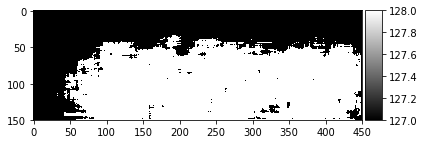

TARGET


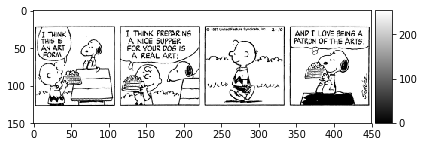

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 35 progress report:
latent shape:  (1, 100)
latent:  [[7.30472471e-02 9.57561262e-01 2.35532892e-01 6.34623329e-01
  6.49162964e-01 1.87056675e-01 9.01663646e-01 8.23357028e-01
  6.89529826e-01 6.71214244e-01 7.42362727e-01 3.80481888e-01
  1.45199596e-01 4.91043174e-01 2.14586905e-01 7.47557029e-01
  1.45432567e-01 4.30706929e-01 2.36224888e-01 8.14852185e-01
  2.59822099e-01 5.10488992e-01 4.13000219e-01 9.56544931e-01
  7.92763427e-01 2.89110715e-01 1.81251459e-01 7.20848746e-01
  6.05421632e-01 7.41493716e-01 6.61840549e-01 8.45010177e-01
  8.19553554e-01 8.92423422e-02 2.06519781e-01 3.41476131e-01
  5.38281490e-03 3.85789747e-01 8.90920240e-01 9.27288069e-01
  8.35430589e-01 1.05041209e-01 4.81042370e-01 4.42278451e-01
  5.07433429e-01 6.16028816e-01 8.91570138e-01 1.90039055e-01
  1.07259756e-01 5.49741111e-01 2.56786777e-01 5.18987056e-01
  7.35864431e-02 7.77820668e-01 9.99190089e-01 9.87147693e-01
  1.60885804e-0

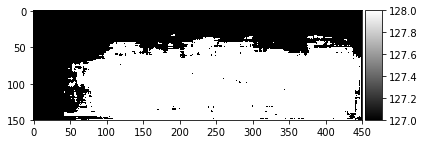

TARGET


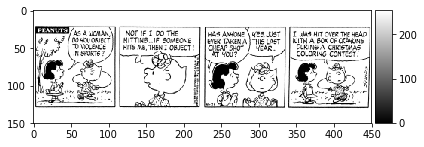

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 36 progress report:
latent shape:  (1, 100)
latent:  [[0.73257572 0.37278652 0.8715603  0.92856687 0.85231825 0.93481227
  0.65591186 0.31597262 0.07692415 0.96173586 0.19505083 0.29778616
  0.21247866 0.96977929 0.12570983 0.28859306 0.00111304 0.38298393
  0.81400261 0.47664503 0.23263758 0.12534013 0.92227704 0.55433871
  0.68775589 0.08903957 0.57190806 0.38446942 0.08573979 0.56771076
  0.38421108 0.94590277 0.85046408 0.75580763 0.60940605 0.68087165
  0.73800179 0.68934366 0.13889355 0.93538958 0.27766868 0.90837092
  0.82403138 0.38221383 0.66759387 0.00177278 0.71388544 0.02681758
  0.36770742 0.54149966 0.18818428 0.85333971 0.71296608 0.3516525
  0.69933429 0.12066187 0.67514882 0.5410699  0.81938652 0.74879616
  0.2788885  0.18982137 0.26426584 0.81168291 0.69824755 0.61442411
  0.84394068 0.51952901 0.08535645 0.21971869 0.21304899 0.1952134
  0.42983414 0.34695944 0.9437783  0.85549322 0.72405638 0.92977168
 

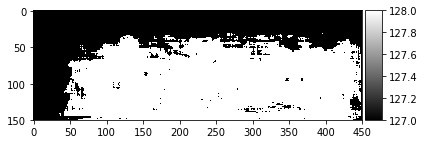

TARGET


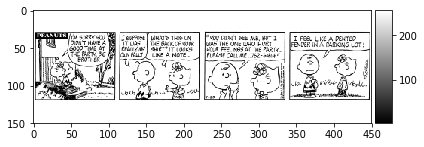

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 37 progress report:
latent shape:  (1, 100)
latent:  [[0.24939393 0.45050444 0.19378715 0.83402393 0.24005555 0.34636744
  0.8340385  0.12674579 0.51258195 0.68491848 0.56764319 0.08760037
  0.17857452 0.5800261  0.37827405 0.57150855 0.07871352 0.31484092
  0.0566098  0.19997238 0.26004857 0.51097077 0.9204459  0.33791755
  0.82117638 0.19136144 0.90491943 0.62059095 0.43110115 0.42227609
  0.58957281 0.61040722 0.42239008 0.22157778 0.3380967  0.42058552
  0.54528679 0.50541329 0.75086173 0.37555201 0.98084605 0.04365362
  0.00687185 0.16586072 0.23181659 0.29108001 0.08953108 0.17314968
  0.24145046 0.23282418 0.34505466 0.49346685 0.46027716 0.06724698
  0.43801316 0.61923682 0.97271564 0.55526929 0.70325658 0.1580381
  0.87922422 0.85083798 0.44067581 0.75836823 0.90227864 0.20573585
  0.48819918 0.81904191 0.43433208 0.79858937 0.57339421 0.59256202
  0.01026691 0.40627022 0.63548643 0.02459366 0.97041671 0.21894577


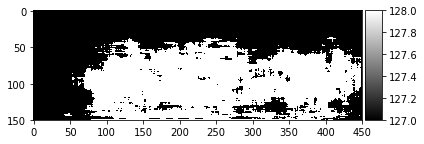

TARGET


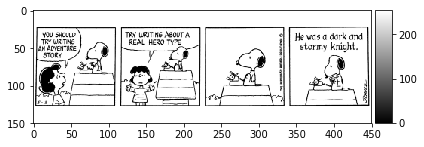

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 38 progress report:
latent shape:  (1, 100)
latent:  [[0.00831041 0.26205298 0.04525774 0.82962799 0.86561969 0.0763054
  0.53050864 0.64456639 0.04907728 0.57471991 0.1098307  0.17501792
  0.40340703 0.92929744 0.31682715 0.81988912 0.61969277 0.67664732
  0.88479897 0.9494214  0.3502376  0.10430602 0.03513208 0.60907826
  0.44014404 0.80491787 0.4564716  0.79237002 0.02667232 0.21469129
  0.14203089 0.73493663 0.76807589 0.4924391  0.62989296 0.63497308
  0.8568989  0.03706633 0.55838152 0.57527175 0.89699372 0.53096648
  0.89256826 0.0499946  0.04323023 0.00366949 0.49289569 0.93275378
  0.34455685 0.64113866 0.34822158 0.20966808 0.97496469 0.79213166
  0.83927362 0.23039279 0.76321811 0.44618258 0.69135675 0.6138458
  0.24138033 0.41776454 0.06034344 0.7531933  0.07161616 0.78876282
  0.53249375 0.15359969 0.73903333 0.00930266 0.50959775 0.27686068
  0.23149454 0.97485284 0.89645215 0.59001054 0.81166517 0.11374866
 

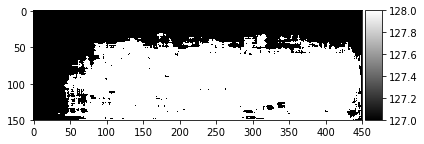

TARGET


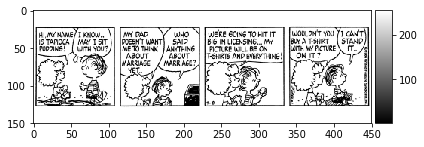

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 39 progress report:
latent shape:  (1, 100)
latent:  [[0.96973733 0.97130623 0.56752661 0.84410917 0.43217882 0.99566765
  0.7880845  0.33451846 0.02014186 0.16120054 0.27929614 0.67749054
  0.4767873  0.19780904 0.20800889 0.01449571 0.82240463 0.88469771
  0.4993714  0.67750712 0.20933363 0.44077764 0.74021682 0.38438938
  0.40048744 0.16439457 0.43167474 0.20500771 0.02264104 0.15512148
  0.2197752  0.3149136  0.77234885 0.51253404 0.54325146 0.76719581
  0.45834854 0.63110867 0.79547518 0.13108579 0.26114842 0.52448401
  0.25667766 0.61119001 0.33593513 0.45293145 0.88112025 0.66503342
  0.1066489  0.82272624 0.17811431 0.24476459 0.17831095 0.81768918
  0.08343054 0.29424043 0.78319532 0.4328281  0.49154157 0.14016595
  0.97192274 0.35815823 0.42663383 0.3251952  0.89280893 0.07637324
  0.4477279  0.6201682  0.70201191 0.81531554 0.03855312 0.27661822
  0.66767944 0.21042025 0.33955709 0.26357773 0.82559346 0.80896226

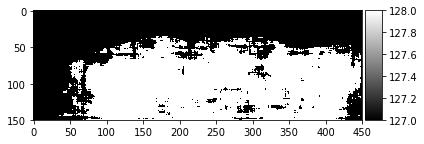

TARGET


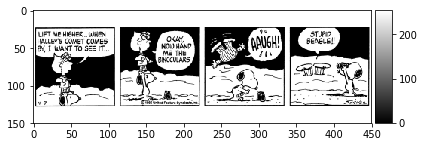

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 40 progress report:
latent shape:  (1, 100)
latent:  [[0.95172689 0.45176229 0.87540469 0.64693604 0.93190172 0.10339918
  0.91343766 0.22548476 0.92632496 0.41452552 0.88754462 0.65684834
  0.92754361 0.3019702  0.56871084 0.66211926 0.98495519 0.26060573
  0.77021006 0.35451671 0.86144006 0.02459737 0.90922181 0.78441807
  0.96803661 0.29524378 0.51494071 0.97890855 0.3877654  0.23252203
  0.94368302 0.26615722 0.80101584 0.66949276 0.52248204 0.18378435
  0.78615214 0.92203742 0.14088458 0.70979713 0.30768703 0.03240633
  0.76993919 0.66160119 0.90150372 0.4693737  0.59900902 0.89558616
  0.31255373 0.28808843 0.98792298 0.46337523 0.75681388 0.22389538
  0.03373335 0.13824994 0.09920837 0.46519832 0.70600544 0.48150167
  0.74749787 0.58074114 0.9620326  0.29998355 0.58519898 0.01480002
  0.09563766 0.19191503 0.94737103 0.89813054 0.61639003 0.8580993
  0.72194128 0.11508175 0.90285357 0.40136715 0.56902374 0.89382441


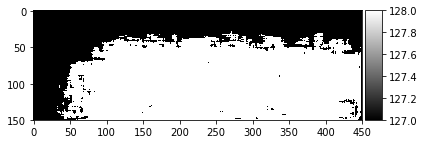

TARGET


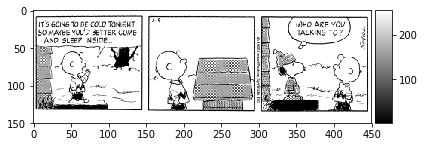

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 41 progress report:
latent shape:  (1, 100)
latent:  [[0.49692766 0.20647497 0.24910505 0.50336506 0.17108779 0.72674936
  0.2521391  0.76862592 0.86526317 0.90356755 0.2762284  0.19067231
  0.33995695 0.21035253 0.41597039 0.81086213 0.97042725 0.42671998
  0.06792282 0.02918112 0.4307211  0.59134765 0.67455523 0.38757495
  0.79876224 0.72669074 0.41580425 0.44743886 0.8793011  0.82040159
  0.41334356 0.0997041  0.91121174 0.50404719 0.64614673 0.64569776
  0.21498112 0.82784223 0.36402506 0.79974319 0.94131168 0.41807472
  0.04516428 0.96408231 0.95035794 0.85478232 0.51758813 0.94101687
  0.75547988 0.34676801 0.67068889 0.40240086 0.18654269 0.6381318
  0.90667646 0.70473273 0.86789384 0.74439664 0.04937621 0.59673739
  0.66756126 0.04894495 0.76974079 0.66541811 0.87848295 0.56378544
  0.12252623 0.2810251  0.08284171 0.89338385 0.01255865 0.31738703
  0.07607947 0.31200991 0.28820653 0.40854044 0.61699276 0.10404803


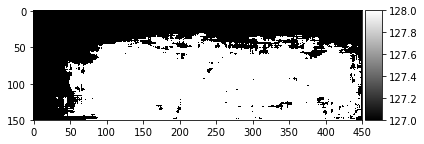

TARGET


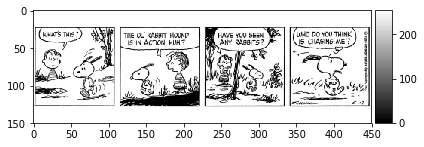

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 42 progress report:
latent shape:  (1, 100)
latent:  [[0.90897329 0.15783729 0.99385276 0.57918899 0.21513171 0.36833431
  0.6321549  0.79449412 0.12570071 0.29696273 0.6879134  0.44312597
  0.28080664 0.66365933 0.87270189 0.91420636 0.54755362 0.85429077
  0.20700199 0.7827993  0.92284824 0.5875172  0.91672239 0.02657933
  0.42769356 0.25710456 0.50372938 0.94933397 0.99436378 0.68303385
  0.14790844 0.18932539 0.30741532 0.83129782 0.58109408 0.15381373
  0.1401368  0.5174648  0.65818734 0.53517469 0.96148528 0.43062648
  0.59920021 0.4485273  0.07411509 0.34775794 0.59946209 0.90580505
  0.15424268 0.4032513  0.64933025 0.32786198 0.69156022 0.87582095
  0.90348054 0.52620205 0.07141104 0.19706034 0.49789721 0.56528304
  0.76790536 0.60793464 0.69955748 0.34385804 0.44197288 0.23633081
  0.81487449 0.71592552 0.28829322 0.99150518 0.99882593 0.03532362
  0.13893132 0.70418002 0.22842309 0.41218193 0.99237297 0.04285357

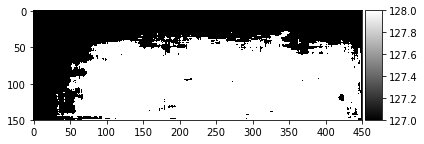

TARGET


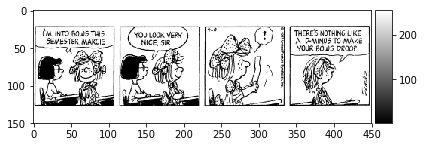

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 43 progress report:
latent shape:  (1, 100)
latent:  [[0.18514819 0.15405632 0.21331104 0.41026613 0.64790905 0.80451139
  0.81932588 0.00476731 0.66234478 0.21165408 0.90721853 0.1052338
  0.99762194 0.13569671 0.3630259  0.04153174 0.4284852  0.79101509
  0.33572069 0.885344   0.23815683 0.92000648 0.78987349 0.98866186
  0.96426035 0.13243682 0.93652737 0.74198313 0.06008459 0.2990612
  0.18562251 0.03796675 0.11909999 0.95995504 0.32424277 0.12940657
  0.05068956 0.37104576 0.11697242 0.024246   0.79834999 0.43673281
  0.02059906 0.49074174 0.84255328 0.1159821  0.6993462  0.21538018
  0.01882455 0.94157873 0.15147908 0.20844726 0.03540647 0.3944542
  0.78657551 0.69609121 0.74299865 0.51616056 0.60583235 0.37562327
  0.80845552 0.37321188 0.05636135 0.54630273 0.57844337 0.10743329
  0.15768108 0.61176524 0.68068314 0.57458279 0.9449773  0.68044274
  0.8100962  0.12376948 0.47112139 0.92938156 0.91943555 0.69114021
  

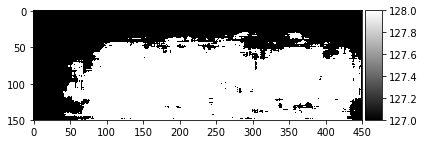

TARGET


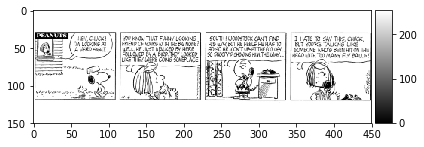

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 44 progress report:
latent shape:  (1, 100)
latent:  [[0.94662972 0.79535183 0.52930265 0.89684524 0.43380023 0.46267665
  0.21502506 0.21456203 0.30438619 0.98900073 0.12875889 0.98048751
  0.15402492 0.88039047 0.94589006 0.14375778 0.65846149 0.63889245
  0.49286777 0.74097039 0.71191215 0.19034676 0.91156246 0.75558553
  0.65185424 0.86995081 0.14621646 0.96836583 0.90402057 0.2662492
  0.57402112 0.01090188 0.19844458 0.5926348  0.63833497 0.18700899
  0.28457162 0.14919356 0.17790027 0.48633523 0.65220957 0.04450611
  0.89378062 0.7322412  0.58981668 0.16513964 0.64020344 0.63822959
  0.69027765 0.92342163 0.82973186 0.30801746 0.94576598 0.73979992
  0.1026222  0.73899659 0.46237755 0.16394033 0.42072672 0.02867677
  0.79784657 0.96198669 0.87105498 0.05510754 0.6139559  0.79312842
  0.25444531 0.61279578 0.73871525 0.49399253 0.20707793 0.71957066
  0.8953616  0.92889967 0.51423632 0.35760522 0.33090428 0.39104606


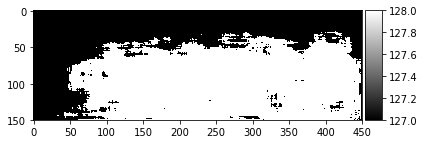

TARGET


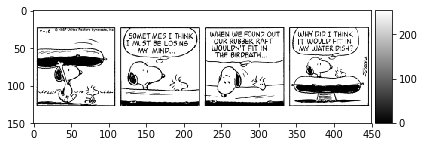

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 45 progress report:
latent shape:  (1, 100)
latent:  [[0.22226522 0.15743472 0.13687062 0.54574037 0.53857001 0.96416232
  0.78998256 0.62058271 0.32367386 0.66338015 0.63681218 0.60502754
  0.52034104 0.76976041 0.8542928  0.29477304 0.45807244 0.80045068
  0.29888475 0.89269343 0.91308103 0.01259941 0.0904476  0.56782728
  0.3004733  0.9870131  0.14534144 0.82616407 0.34579902 0.85667231
  0.1077841  0.88464907 0.76268473 0.92623687 0.76703673 0.06789648
  0.80391572 0.80205974 0.24197886 0.96252597 0.87728189 0.2822874
  0.16494246 0.99139411 0.84938982 0.25756644 0.39399853 0.36263243
  0.83864073 0.54317822 0.40860006 0.11192944 0.0157652  0.31480416
  0.72664707 0.33802196 0.98030132 0.34398924 0.77884875 0.7108608
  0.65180598 0.90523344 0.77148851 0.84990358 0.41298739 0.86993897
  0.01259002 0.9026271  0.45318351 0.41838326 0.61521562 0.59741604
  0.80729254 0.45272627 0.01138009 0.31245947 0.27962985 0.77410253
 

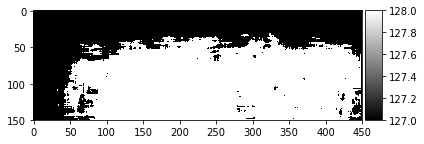

TARGET


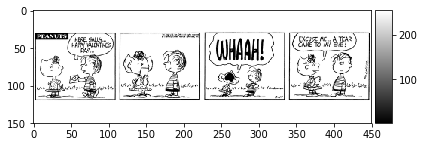

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 46 progress report:
latent shape:  (1, 100)
latent:  [[3.40949714e-01 3.77398612e-01 5.17558881e-01 8.37030954e-01
  4.15863083e-01 6.76050695e-01 2.74848746e-01 4.15639590e-01
  3.16712939e-01 7.98012511e-02 8.10409907e-01 6.63395123e-01
  7.46676291e-01 4.51529437e-01 9.39540313e-01 9.85164919e-01
  3.79776092e-01 4.05958183e-01 9.77128103e-01 9.88503045e-01
  3.44561925e-01 1.57900325e-01 9.62552454e-01 9.60794834e-01
  5.97805734e-01 3.44678175e-01 1.66548311e-01 4.46711134e-01
  8.54697538e-01 1.70941437e-01 7.63092626e-01 1.77354619e-01
  7.86856683e-01 8.77826827e-01 9.03310813e-01 2.20455427e-02
  3.69728704e-02 9.67768982e-01 4.62481455e-01 5.31478597e-01
  1.76400258e-01 2.11044325e-02 8.37707757e-01 9.02830503e-01
  5.55826366e-01 3.30001804e-02 8.30081758e-01 8.99327338e-01
  3.78346293e-01 1.39064924e-01 8.95079919e-01 4.04836349e-02
  8.62757571e-01 5.84475487e-01 6.23203127e-01 3.33490727e-01
  9.16854840e-0

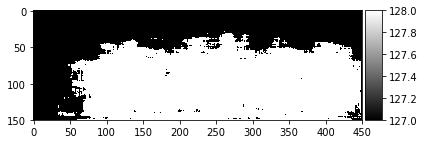

TARGET


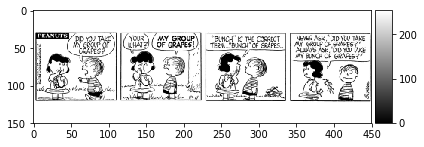

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 47 progress report:
latent shape:  (1, 100)
latent:  [[0.56901431 0.12913496 0.28995391 0.09794386 0.70532789 0.73016601
  0.365886   0.44495659 0.13017014 0.02634584 0.61722042 0.51883903
  0.05078272 0.55053584 0.34513688 0.31324408 0.14079655 0.92939843
  0.20007536 0.0645773  0.24163846 0.54550737 0.18126179 0.60511798
  0.42712198 0.99621757 0.11982447 0.63156012 0.10478985 0.38340534
  0.13675025 0.97895188 0.3785578  0.64050736 0.11535648 0.25135769
  0.72094704 0.0036222  0.62199207 0.73907462 0.86614716 0.81848882
  0.27632151 0.10319776 0.96486156 0.48258111 0.00684255 0.76518964
  0.59565507 0.16983125 0.16408912 0.92158239 0.70548419 0.57282563
  0.28813738 0.00909662 0.23222865 0.93890044 0.19575572 0.78774056
  0.60226761 0.51988742 0.22364279 0.93882346 0.23226737 0.77400564
  0.64375649 0.65158208 0.45717708 0.80545845 0.25543253 0.15650068
  0.16290181 0.86672078 0.46758711 0.16348715 0.10956325 0.24219306

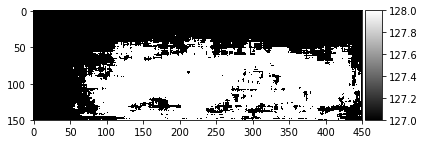

TARGET


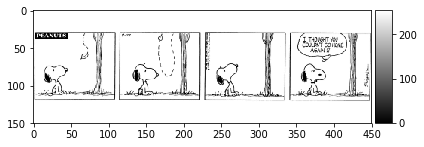

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 48 progress report:
latent shape:  (1, 100)
latent:  [[4.13573772e-01 8.64923584e-01 4.17958610e-01 9.79785812e-01
  9.87681893e-01 6.36201725e-02 7.20565149e-01 5.99267969e-01
  6.66031286e-01 7.45202465e-01 6.96669351e-01 5.95069329e-01
  2.71191775e-01 7.20735280e-01 6.74677858e-01 5.42040331e-02
  6.40605737e-02 2.15325718e-01 2.63506228e-02 9.34626266e-01
  3.08599089e-01 8.58228946e-01 7.71631101e-01 4.75071447e-01
  3.56082838e-02 9.71794980e-01 5.36450550e-01 3.17628335e-01
  3.17971217e-01 4.15116045e-01 1.18121199e-01 5.60730729e-01
  9.59499909e-01 2.63707963e-01 4.76443691e-01 1.09235706e-01
  9.94097366e-01 4.28343046e-01 1.42216320e-01 8.38629037e-01
  2.07023986e-01 4.95362919e-01 2.48415989e-02 3.62962746e-01
  4.48474118e-01 2.28141885e-01 7.78142545e-01 5.04167347e-01
  4.95768419e-01 6.35393673e-01 7.05063706e-01 8.17208835e-01
  5.23609277e-01 4.14440612e-01 3.16696511e-01 1.89442907e-01
  6.29192053e-0

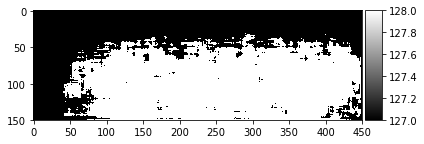

TARGET


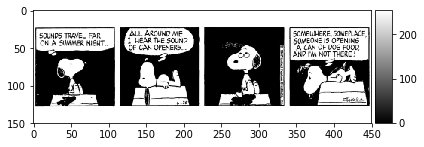

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 49 progress report:
latent shape:  (1, 100)
latent:  [[0.73263387 0.87667538 0.36190709 0.80577044 0.94608482 0.07626646
  0.41345895 0.4681156  0.63296086 0.60253313 0.92194927 0.51876914
  0.2168635  0.08752682 0.98320109 0.55442361 0.57442181 0.10349807
  0.76815611 0.53661163 0.18601743 0.1219337  0.05387155 0.14703035
  0.6466538  0.26432202 0.01560596 0.34030363 0.20418724 0.86254239
  0.75641085 0.96379446 0.10868644 0.56971543 0.09236377 0.70075776
  0.88591563 0.66675163 0.04785543 0.66471627 0.47303138 0.90109368
  0.98733477 0.43213746 0.17594297 0.0715701  0.49905282 0.730998
  0.55150614 0.14699193 0.30754508 0.55752082 0.37442006 0.86914484
  0.11842889 0.21727502 0.17153249 0.39514265 0.57709879 0.27746541
  0.09095341 0.33571933 0.56093345 0.47350571 0.95374834 0.8599002
  0.85124727 0.51576289 0.69874241 0.32390019 0.49184323 0.66503763
  0.68314112 0.54704238 0.72010217 0.91341793 0.09750535 0.91509351
  

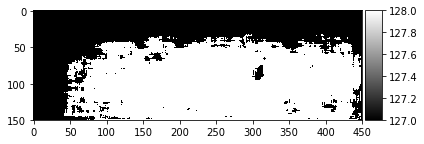

TARGET


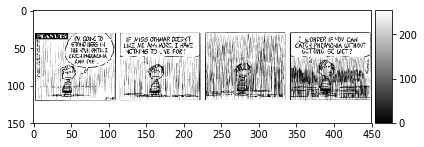

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 50 progress report:
latent shape:  (1, 100)
latent:  [[0.134639   0.15194926 0.41231884 0.88065908 0.09076602 0.78910782
  0.55210006 0.1687547  0.29288957 0.13008479 0.42487067 0.78878673
  0.70722466 0.97736973 0.6840292  0.04442904 0.93228712 0.82366524
  0.86604018 0.59115888 0.34673513 0.63033321 0.03300258 0.39678225
  0.01934634 0.9810569  0.70907707 0.55285946 0.43671619 0.10011611
  0.26683521 0.47433324 0.61670506 0.51180088 0.45524831 0.89279643
  0.85619915 0.58150551 0.95866076 0.18614148 0.00689451 0.98831336
  0.69712011 0.61035042 0.66588596 0.71828965 0.53466536 0.79569936
  0.33596552 0.40725714 0.28427489 0.31390724 0.2082641  0.25271422
  0.13122456 0.31998391 0.97502384 0.00480059 0.33583853 0.44100276
  0.78113912 0.31262862 0.04865006 0.32727329 0.73817697 0.27798288
  0.64415304 0.58337017 0.44085884 0.16158631 0.12290364 0.4612242
  0.11135188 0.12610553 0.22929701 0.16242133 0.7695189  0.85505953


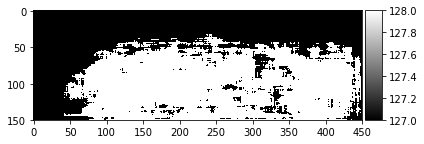

TARGET


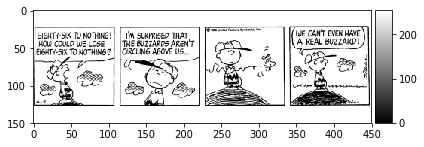

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 51 progress report:
latent shape:  (1, 100)
latent:  [[0.15016034 0.55561636 0.82734869 0.69884725 0.62298659 0.78834501
  0.82030242 0.01921687 0.36094709 0.41010307 0.23957781 0.91709329
  0.5836101  0.43389236 0.36027893 0.26452641 0.52800708 0.41863949
  0.00618104 0.75879634 0.35099586 0.9481432  0.40225106 0.03224967
  0.44904125 0.33824668 0.12890384 0.15583591 0.5280684  0.53035995
  0.89651984 0.36739073 0.52511681 0.5537939  0.53087913 0.49121105
  0.3928152  0.97624869 0.27034334 0.66293231 0.64853944 0.6649778
  0.7292685  0.24407616 0.82149851 0.36350482 0.45579199 0.31853332
  0.47379002 0.49855588 0.55214545 0.32307688 0.6170399  0.53168848
  0.45988445 0.52876948 0.69353728 0.37236036 0.68246672 0.25347301
  0.57772172 0.07885824 0.23014782 0.28837039 0.01256638 0.00704421
  0.97106178 0.52567356 0.83610642 0.57838284 0.10417505 0.37844708
  0.34555253 0.40389242 0.72168708 0.95689956 0.18993686 0.45248542


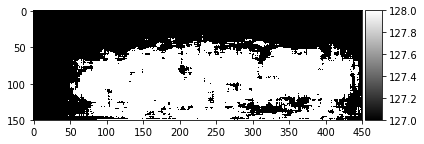

TARGET


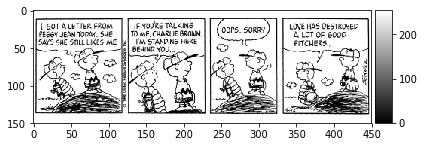

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 52 progress report:
latent shape:  (1, 100)
latent:  [[0.50796317 0.72091322 0.74971204 0.96970632 0.77575475 0.49681541
  0.0988321  0.71484715 0.38180283 0.41199567 0.63256101 0.57622114
  0.11938709 0.65374907 0.07049482 0.97425478 0.87571916 0.20061013
  0.40961949 0.71003157 0.09738047 0.64236815 0.1694652  0.90728305
  0.68447263 0.47532415 0.64912875 0.96220729 0.92125907 0.5829187
  0.83443957 0.06362057 0.09098268 0.04833027 0.4063051  0.4371845
  0.29960425 0.74608913 0.24780178 0.9133821  0.35778176 0.06740632
  0.92332646 0.64687601 0.54514854 0.37605039 0.01979227 0.78557016
  0.6086597  0.00350858 0.05480936 0.48839719 0.62139294 0.89416562
  0.43008944 0.96764103 0.14004396 0.73691588 0.97152057 0.72037217
  0.52885152 0.83958361 0.33057606 0.21290514 0.13337942 0.6368061
  0.0676212  0.40011995 0.03072671 0.9743765  0.88277509 0.87687079
  0.88649677 0.17696475 0.2590913  0.50078037 0.61564481 0.7155418
  0

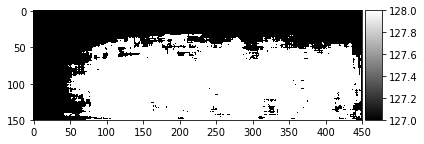

TARGET


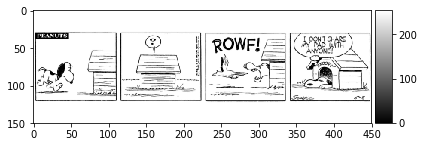

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 53 progress report:
latent shape:  (1, 100)
latent:  [[0.91564604 0.76227332 0.96233607 0.66473343 0.96011877 0.00640247
  0.59888338 0.58540095 0.07958333 0.44326838 0.75529734 0.68916273
  0.6598422  0.40031916 0.44028137 0.47435096 0.8022612  0.28681615
  0.0952365  0.43340453 0.57871769 0.3162997  0.88163574 0.50443699
  0.71397265 0.10343703 0.40441056 0.41000587 0.04399892 0.91044467
  0.83528112 0.28292053 0.90363002 0.30247187 0.84263946 0.30683403
  0.26378401 0.82172096 0.22654185 0.85718333 0.24118878 0.8255243
  0.82138568 0.39143333 0.90467145 0.2382284  0.34466787 0.56041896
  0.24208004 0.29743015 0.95261238 0.63037259 0.69631028 0.71869998
  0.76135909 0.4305031  0.53127419 0.58255053 0.2067527  0.64411562
  0.04498998 0.21454518 0.07306039 0.45671759 0.8553454  0.72062461
  0.78789489 0.34828931 0.70055504 0.00730958 0.59976822 0.58269879
  0.99118053 0.621178   0.27206482 0.55587858 0.58365482 0.16872309


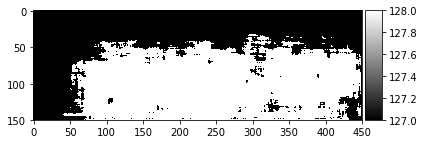

TARGET


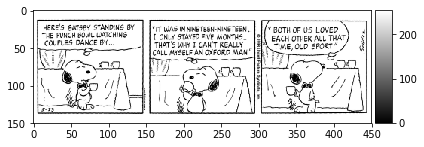

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 54 progress report:
latent shape:  (1, 100)
latent:  [[0.05542193 0.69297283 0.42411388 0.02476995 0.36789338 0.42292588
  0.71610576 0.22269022 0.30875612 0.98755257 0.81523611 0.98737405
  0.61032732 0.17819174 0.5431939  0.84119156 0.05648989 0.50515688
  0.46814668 0.20706739 0.52316403 0.0884366  0.57584753 0.3487041
  0.63596354 0.70324894 0.88075768 0.03665256 0.18384183 0.75431165
  0.93014021 0.96434245 0.01534279 0.68310936 0.06125635 0.7042195
  0.42956969 0.17324135 0.33578236 0.61327351 0.9758308  0.45768735
  0.3649667  0.49373516 0.09803706 0.026465   0.52593024 0.97428955
  0.22285017 0.52414652 0.97765896 0.08437535 0.28200348 0.81236229
  0.39788954 0.64755203 0.06338629 0.61299165 0.51580406 0.16346598
  0.59998134 0.31349929 0.37431047 0.40617338 0.98811699 0.48741752
  0.02560156 0.56371816 0.95609329 0.65741213 0.36285294 0.12861816
  0.3591285  0.83300017 0.2716201  0.49011702 0.86316753 0.84895252
 

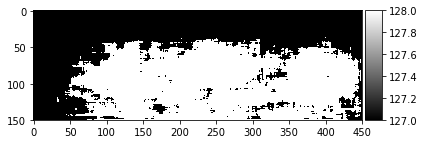

TARGET


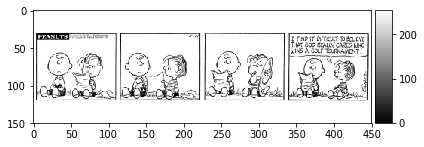

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 55 progress report:
latent shape:  (1, 100)
latent:  [[0.59197666 0.21180237 0.35493068 0.97893559 0.83586586 0.39060199
  0.85462658 0.61007576 0.34599527 0.39665118 0.02083503 0.21677953
  0.06310603 0.34277122 0.55532999 0.52091272 0.7624502  0.81768801
  0.92493474 0.27226051 0.09649176 0.23782252 0.68208951 0.20064075
  0.59030138 0.71789272 0.74152604 0.4142555  0.40087525 0.86354524
  0.99662452 0.4477959  0.46505663 0.57862658 0.79770974 0.53201833
  0.26532831 0.66832478 0.51340116 0.87753883 0.96331651 0.37583732
  0.22479219 0.74039888 0.23576917 0.32647125 0.35907162 0.58414523
  0.23331368 0.52002239 0.31923915 0.50977084 0.42420521 0.63530516
  0.88722981 0.94126939 0.13303542 0.84159411 0.1940368  0.63387536
  0.42510308 0.14496017 0.43787424 0.09859464 0.03702998 0.10880826
  0.46650566 0.80772074 0.97914579 0.42635427 0.54188374 0.25806108
  0.7753417  0.15047689 0.80080306 0.80329001 0.90898225 0.56843447

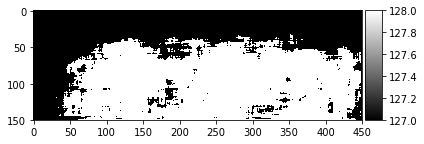

TARGET


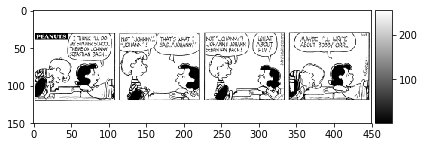

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 56 progress report:
latent shape:  (1, 100)
latent:  [[0.36786047 0.61085208 0.15521397 0.54082929 0.99460736 0.31231957
  0.41661063 0.31988059 0.80909572 0.42948539 0.0622131  0.79540216
  0.8773981  0.28821075 0.43232872 0.79323258 0.39648616 0.11783855
  0.60500686 0.8947076  0.26620191 0.64918406 0.54464662 0.39822663
  0.83865783 0.03393052 0.13500385 0.33019848 0.11626507 0.44541435
  0.48190679 0.02093882 0.3216751  0.45949514 0.21985792 0.23847227
  0.42705846 0.2943903  0.43711239 0.6659239  0.16748568 0.82750014
  0.87916746 0.5092928  0.31398691 0.17359909 0.45768945 0.88286646
  0.09873464 0.73919865 0.47913559 0.59321676 0.6178005  0.67705015
  0.08185259 0.97138134 0.07497074 0.37946927 0.63933204 0.83679932
  0.29185917 0.77444748 0.33377325 0.19762641 0.86708337 0.08208902
  0.22619489 0.41631047 0.24950295 0.31769951 0.82640102 0.47730896
  0.70880587 0.02968451 0.74398001 0.75015229 0.79584141 0.35904065

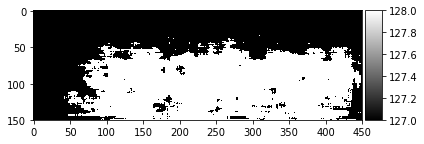

TARGET


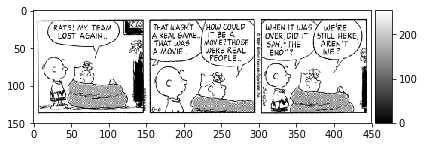

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 57 progress report:
latent shape:  (1, 100)
latent:  [[0.46221506 0.97759697 0.17000862 0.18874028 0.81694474 0.55436376
  0.09251622 0.87366824 0.2141582  0.706887   0.03655309 0.624914
  0.38369096 0.25102172 0.29044227 0.01788576 0.79717998 0.30661656
  0.6280561  0.99410113 0.36569902 0.30303684 0.48917    0.77166438
  0.67861227 0.89667788 0.28367307 0.65666186 0.54312277 0.37540769
  0.61785884 0.84695753 0.52288919 0.58131319 0.21903304 0.60748801
  0.76357708 0.53931008 0.04082546 0.25803452 0.73714073 0.61155173
  0.27300425 0.72921669 0.77171621 0.56793567 0.67880887 0.23315625
  0.83940133 0.31089528 0.78111049 0.63032061 0.75835519 0.46157048
  0.68231624 0.87622686 0.0606452  0.17917723 0.28448267 0.64740224
  0.82597413 0.00897503 0.50356382 0.56271472 0.84681474 0.83895387
  0.91106436 0.3505675  0.81523079 0.74632855 0.46848258 0.68077234
  0.28437981 0.50371492 0.16884545 0.36535357 0.16141986 0.27631886
 

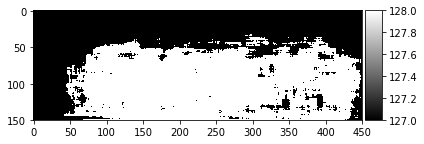

TARGET


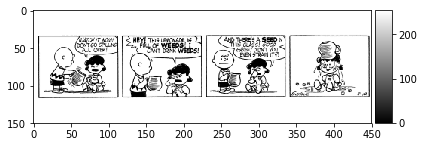

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 58 progress report:
latent shape:  (1, 100)
latent:  [[0.77019923 0.05058932 0.90837108 0.00261428 0.86232626 0.71218001
  0.60829486 0.58793108 0.97493585 0.92507493 0.2071053  0.05274525
  0.94008505 0.99509296 0.52699788 0.01131329 0.50409135 0.83035531
  0.3645729  0.9335023  0.11768148 0.45903298 0.42719216 0.14316912
  0.22084802 0.51655297 0.14831932 0.85534429 0.43135537 0.67921204
  0.27544176 0.01444751 0.49228896 0.10337465 0.44078974 0.9974802
  0.7595787  0.39836758 0.60692336 0.54296286 0.13572791 0.65328757
  0.93460081 0.84032969 0.0626843  0.56226328 0.36633304 0.23488465
  0.3888946  0.76833017 0.41385157 0.5001223  0.23989886 0.58434597
  0.66777601 0.11870384 0.40153958 0.56727699 0.54548843 0.85779822
  0.44642579 0.81983599 0.09087423 0.60878513 0.13378804 0.94934912
  0.40641013 0.4024448  0.0423897  0.98213542 0.44547908 0.87834254
  0.8531787  0.03255142 0.74134382 0.84539456 0.16610136 0.10661287


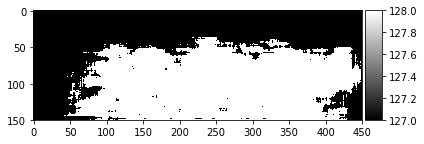

TARGET


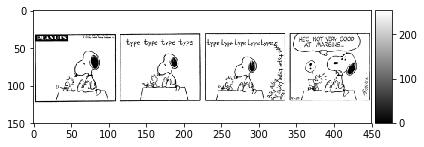

step  1000 / 1000 d_loss:  8.05904769897461 g_loss:  10.0
epoch 59 progress report:
latent shape:  (1, 100)
latent:  [[0.95668791 0.84308175 0.50644342 0.87528101 0.03178833 0.08702258
  0.75106457 0.52795372 0.41776609 0.73035989 0.48135195 0.782259
  0.16254547 0.1618717  0.88494462 0.68174833 0.49732168 0.41152892
  0.09849104 0.79174855 0.06161616 0.09937656 0.24283397 0.27968769
  0.38067054 0.1427652  0.74466729 0.6247773  0.45192323 0.5446289
  0.58593127 0.02582673 0.60882386 0.08148162 0.63379894 0.18099968
  0.14536903 0.85764575 0.10447608 0.8011471  0.44963862 0.71702102
  0.22704199 0.39072738 0.73196813 0.6660219  0.31468565 0.85932915
  0.5701807  0.64662813 0.44658211 0.90871849 0.87930303 0.12329485
  0.9925474  0.64858365 0.68381904 0.99212435 0.77800193 0.54160031
  0.40511643 0.34099207 0.87879358 0.45801425 0.88346829 0.58635791
  0.29945153 0.7854007  0.2729577  0.92781274 0.19497287 0.23020168
  0.41581327 0.84254646 0.14860537 0.31585398 0.7421785  0.43819975
  

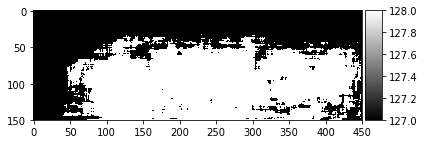

TARGET


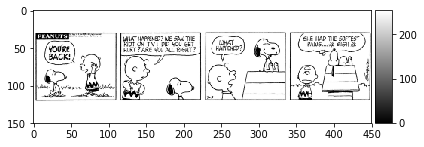

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

In [11]:
test_gan(g_input, g_output, d_input, d_output, first_category_only=True, epochs=60, g_lr=.00001, d_lr=.00001, gan_lr=.00001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       30566209  
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 30,566,273
Trainable params: 30,544,321
Non-trainable params: 21,952
_________________________________________________________________
epoch None progress report:
latent shape:  (1, 100)
latent:  [[5.03194149e-01 7.12300051e-02 6.59512319e-01 2.43103281e-01
  5.10161768e-01 8.83115224e-01 9.05384995e-01 9.81029726e-01
  1.18034855e-01 5.37352666e-01 2.61519143e-01 7.49370361e-04
  6.21116601e-01 9.18315230e-01 9.18642070e-01 6.67008747e-01
  6.81610137e-01 8.94693026e-01 1.75353018e-01 6.85276087e-01
  6.58779084e-01 2

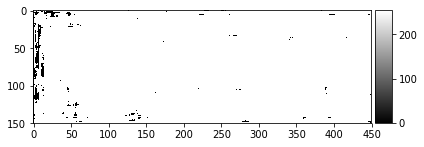

TARGET


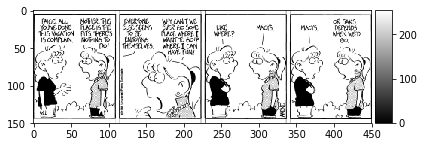

KeyboardInterrupt: 

In [39]:
lrs = []
losses = []
for g_lr in np.logspace(-1, -4, 4):
    for d_lr in np.logspace(-1, -4, 4):
        for gan_lr in np.logspace(-1, -4, 4):
            lrs.append([g_lr, d_lr, gan_lr])
            losses = np.array([test_gan(g_input, g_output, d_input, d_output, epochs=5, first_category_only=True, g_lr=g_lr, d_lr=d_lr, gan_lr=gan_lr)])
            loss_name = "LR_TEST_glr" + g_lr + "_dlr" + d_lr + "_ganlr" + gan_lr + ".txt"
            losses.tofile(loss_name, sep=' ')
lrs = np.array(lrs)
#losses = np.array(losses)
lrs.tofile("LR_TEST_lrs.txt", sep=' ')
#losses.tofile("LR_TEST_losses.txt", sep=' ')

In [37]:
print(len(losses))

7


more layrs?
loss function?  scale back dropout? pretrain discriminator?

### Parameterized Generation

#### Concatenating a one-hot vector

In [ ]:
# NOTE: this only works under the assumption that the input image dimension is larger in pixels than the number of categories
# TODO: this just replaces the first strip rn, but I'm not fixing it rn cause that would require messing with the shape
def concat_with_one_hot(img, latent_category):
    one_hot_vector = np.zeros(img.shape[1])
    one_hot_vector[latent_category] = 1
    img[0] = one_hot_vector # TODO: should it matter which is first or along which dimension?  investigate
    return img
    

In [ ]:
g_input = Input(shape=(150, 450, 1))
layer = Conv2DTranspose(8, 4, strides=1, padding='same')(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
for _ in range(10):
    layer = Conv2DTranspose(8, 4, strides=1, padding='same')(layer)
    layer = BatchNormalization(momentum=.9)(layer)
    layer = PReLU()(layer)
layer = Conv2DTranspose(1, 4, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

In [ ]:
test_gan(g_input, g_output, d_input, d_output, first_category_only=True, input_method=concat_with_one_hot)